# Skin cancer detection

## Business Problem
Skin cancer is by far the most common type of cancer.
<br>According to one estimate, about 5.4 million cases of skin cancer are diagnosed among
3.3 million people each year. (Many people are diagnosed with more than one spot of
skin cancer at the same time.)
<br>The number of skin cancers among people older than 50 has been increasing for many
years. This is probably from a combination of better skin cancer detection, people
getting more sun exposure, and people living longer.
1 out of 5 Americans will develop skin cancer by the time they are 70.
<br>What Does Skin Cancer Look Like?
<br>Skin cancers can look quite different from one person to another due to skin tone, size
and type of skin cancer and location on the body.
<br>**Causes:** Skin cancer occurs when errors (mutations) occur in the DNA of skin cells. The
mutations cause the cells to grow out of control and form a mass of cancer cells.
<br>**Risk factors:** Fair skin, light hair, freckling, moles, history of sunburns, excessive sun exposure, sunny or high-altitude climates, precancerous skin lesions, weakened
immune system and the list goes on.
<br>If you have skin cancer, it is important to know which type you have because it affects
your treatment options and your outlook (prognosis). If you aren’t sure which type of
skin cancer you have, what is recommended is that you ask your doctor so you can get
the right information.
<br>A Doctor will usually do an examination looking at all the skin moles, growths
and abnormalities to get a sense of which ones are at risk for being cancerous.
<br>But what if the Doctor is not sure?
<br>What if we could develop a tool that could help him/her make a determination with
more confidence and ensure more safety for every patient?
<br>What if, in order to make a decision about a patient, the Doctor could have the support
of advanced technology and a model that makes its determination based on a direct
comparison with thousands of other cases?
<br>This is what I am trying to achieve with my project.

Sources:
<br>[Cancer.org/skin-cancer](https://www.cancer.org/cancer/skin-cancer.html)
<br>[Cancer.org/skin-cancer-statistics](https://www.cancer.org/cancer/melanoma-skin-cancer/about/key-statistics.html)
<br>[Skincancer.org](https://www.skincancer.org/skin-cancer-information/)
<br>[MayoClinic/Skin-cancer](https://www.mayoclinic.org/diseases-conditions/skin-cancer/symptoms-causes/syc-20377605#:~:text=Skin%20cancer%20%E2%80%94%20the%20abnormal%20growth,squamous%20cell%20carcinoma%20and%20melanoma.)

## Summary:

> Here talk about how we are building two models, one to identify which one of the 9 classes our image belongs to, and the other one to determine if it's a benign or malignant one.

## The Data
The dataset was taken from Kaggle at the following link:
[Skin Cancer ISIC](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic).
<br>This set consists of 2357 images of malignant and benign oncological diseases, which
were formed from The International Skin Imaging Collaboration (ISIC).
<br>The raw data comes from the [ISIC Archive](https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main).
<br>The data contains images of skin anomalies that belong to 9 different classes.
<br>All images were sorted according to the classification taken with ISIC.

The data is stored in folders, already divided between train and test.
<br>The train contains 2239 images and the test contains 118 images. The images are in the
jpg format.
<br>The only two variables are the pictures and their labels, which identify the type of skin
anomaly. 
<br>The different classes are:
- actinic keratosis
- basal cell carcinoma
- dermatofibroma
- melanoma
- nevus
- pigmented benign keratosis
- seborrheic keratosis
- squamous cell carcinoma
- vascular lesion
<br>For the train the percentages for each class are the following: actinic keratosis 5%, basal
cell carcinoma 17%, dermatofibroma 4%, melanoma 20%, nevus 16%, pigmented benign
keratosis 21%, seborrheic keratosis 3%, squamous cell carcinoma 8%, vascular lesion
6%.

Let us proceed with some imports and then we will import the data.

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits, load_sample_images
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import FunctionTransformer
#from sklearn.compose import make_column_transformer

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier

from lime import lime_image
from skimage.segmentation import mark_boundaries

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

Loading the images form the two different folders, train and test,  in which they are divided in subfolders of the 9 different classes.
<br>We could load a smaller batch or smaller resolution but since we are going to need all these images to run the final model we will directly import them all, in full size.

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images)
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Get all the data in the directory data/test (118 images)
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Create the datasets
train_images_fs, train_labels = next(train_generator)
test_images_fs, test_labels = next(test_generator)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


### Data Understanding:
Let us dig deeper into what each one of these classes are, and we will preview one image for each class to get a visual sense of what our model is going to be studying.

In paricular we will divide the classes in two marco classes, benign and malignant, since we will also build a model to determine if the image is ultimately of benign or cancerous nature.

### Benign Classes:

**Dermatofibroma**
<br>Dermatofibroma is a commonly occurring cutaneous entity usually centered within the skin's dermis. Dermatofibromas are referred to as benign fibrous histiocytomas of the skin, superficial/cutaneous benign fibrous histiocytomas, or common fibrous histiocytoma. 
<br>These mesenchymal cell lesions of the dermis clinically are firm subcutaneous nodules that occur on the extremities in the vast majority of cases and may or may not be associated with overlying skin changes. 
<br>They are most commonly asymptomatic and usually relatively small, less than or equal to 1 centimeter in diameter.
Let us preview a picture of it:

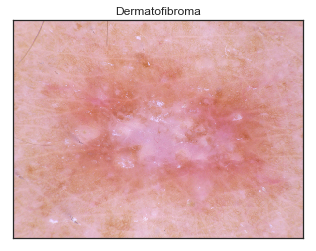

In [3]:
img = mpimg.imread('dataskin/Train/dermatofibroma/ISIC_0025223.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Dermatofibroma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Pigmented benign keratosis and Seborrheic keratosis**
<br>They are both benign keratosis, in fact most of the times they are classified together.
A seborrheic keratosis is a common noncancerous (benign) skin growth. People tend to get more of them as they get older.

Seborrheic keratoses are usually brown, black or light tan. The growths (lesions) look waxy or scaly and slightly raised. They appear gradually, usually on the face, neck, chest or back.
Seborrheic keratoses are harmless and not contagious. 

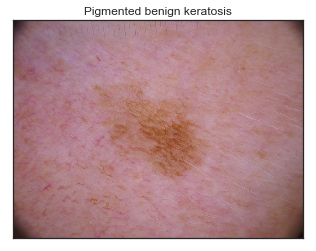

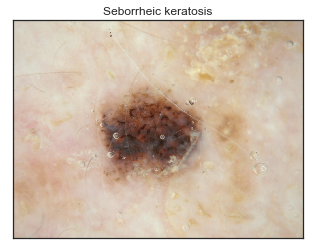

In [4]:
img = mpimg.imread('dataskin/Train/pigmented benign keratosis/ISIC_0024435.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Pigmented benign keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();
img = mpimg.imread('dataskin/Train/seborrheic keratosis/ISIC_0010810.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Seborrheic keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Nevus**
<br>Moles (nevi) are a common type of skin growth. They often appear as small, dark brown spots and are caused by clusters of pigment-forming cells (melanocytes). Most people have 10 to 40 moles that appear during childhood and adolescence and may change in appearance or fade over time.

Most moles are harmless. Rarely, they become cancerous. Being aware of changes in your moles and other pigmented patches is important to detecting skin cancer, especially malignant melanoma.

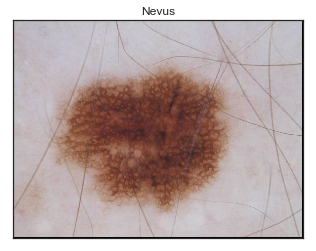

In [5]:
img = mpimg.imread('dataskin/Train/nevus/ISIC_0000019.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Nevus')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Vascular lesion**
<br>Cutaneous vascular lesions are the most common pediatric birthmarks. Flat vascular malformations tend to persist, but raised vascular lesions, known as hemangiomas, generally involute.
Vascular birthmarks are commonly encountered in children and are classified as either hemangiomas or vascular malformations. 
<br>Hemangiomas are benign neoplastic proliferations of vascular endothelial cells characterized by spontaneous involution. In contrast, vascular malformations are not neoplasms but permanent morphogenic abnormalities of capillaries, veins, arteries or lymphatic vessels. <br>Flat lesions (vascular malformations) tend to persist, while raised lesions (hemangiomas) tend to regress.

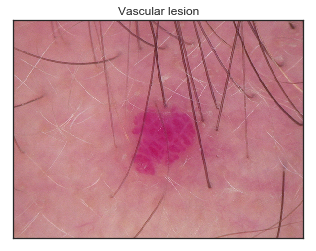

In [6]:
img = mpimg.imread('dataskin/Train/vascular lesion/ISIC_0024475.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Vascular lesion')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

### Malignant Classes:
**Actinic keratosis**
<br>An actinic keratosis is a rough, scaly patch on the skin that develops from years of sun exposure. It's often found on the face, lips, ears, forearms, scalp, neck or back of the hands.
<br>Actinic keratoses (AKs) are premalignant since they may progress to squamous cell carcinoma. They are a common skin condition and develop in sun-exposed skin of individuals with cumulative sun exposure.
<br>Also known as a solar keratosis, an actinic keratosis grows slowly and usually first appears in people over 40.
<br>Left untreated, the risk of actinic keratoses turning into a type of skin cancer called squamous cell carcinoma is about 5% to 10%. 

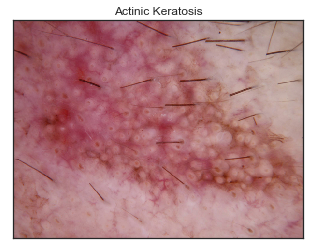

In [7]:
img = mpimg.imread('dataskin/Train/actinic keratosis/ISIC_0025780.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Actinic Keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Basal cell carcinoma**
<br>Basal cell carcinoma is a type of skin cancer. Basal cell carcinoma begins in the basal cells — a type of cell within the skin that produces new skin cells as old ones die off.

Basal cell carcinoma often appears as a slightly transparent bump on the skin, though it can take other forms. Basal cell carcinoma occurs most often on areas of the skin that are exposed to the sun, such as your head and neck.

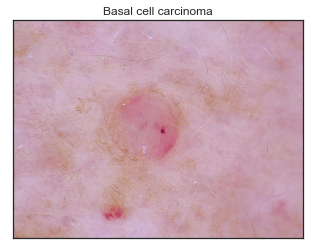

In [8]:
img = mpimg.imread('dataskin/Train/basal cell carcinoma/ISIC_0024572.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Basal cell carcinoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Melanoma**
<br>Melanoma, the most serious type of skin cancer, develops in the cells (melanocytes) that produce melanin — the pigment that gives your skin its color. Melanoma can also form in your eyes and, rarely, inside your body, such as in your nose or throat.

The exact cause of all melanomas isn't clear, but exposure to ultraviolet (UV) radiation from sunlight or tanning lamps and beds increases your risk of developing melanoma.
<br>The risk of melanoma seems to be increasing in people under 40, especially women. Knowing the warning signs of skin cancer can help ensure that cancerous changes are detected and treated before the cancer has spread. Melanoma can be treated successfully if it is detected early.

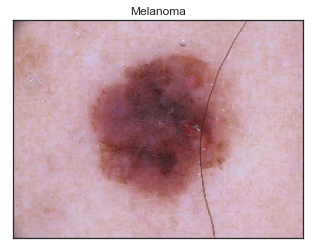

In [9]:
img = mpimg.imread('dataskin/Train/melanoma/ISIC_0000139.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Melanoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Squamous cell carcinoma**
<br>Squamous cell carcinoma of the skin is a common form of skin cancer that develops in the squamous cells that make up the middle and outer layers of the skin.

Squamous cell carcinoma of the skin is usually not life-threatening, though it can be aggressive. Untreated, squamous cell carcinoma of the skin can grow large or spread to other parts of your body, causing serious complications.

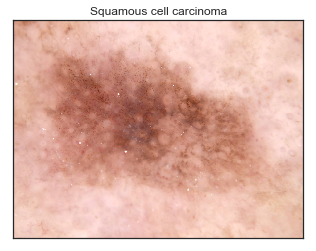

In [10]:
img = mpimg.imread('dataskin/Train/squamous cell carcinoma/ISIC_0024843.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Squamous cell carcinoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

All these informations are taken from the [Mayo Clinic Website](https://www.mayoclinic.org/.) the [National Canter of Biotechonology Website](https://www.ncbi.nlm.nih.gov/) and the [American Family Physician Website](https://www.aafp.org/).

### From the Data Science point of view:

The images are expressed as matrices in which each value represent the pixel value, and specifically each image is comprised of 3 matrices overlapped, one for color Red, one for Green and one for Blue.

> maybe add a picture here from one of the lessons?

In [11]:
train_images_fs[0]

array([[[53., 36., 18.],
        [54., 37., 17.],
        [61., 40., 21.],
        ...,
        [37., 28., 23.],
        [31., 21., 19.],
        [25., 20., 16.]],

       [[58., 41., 23.],
        [66., 43., 25.],
        [65., 42., 24.],
        ...,
        [36., 26., 25.],
        [32., 26., 26.],
        [33., 21., 21.]],

       [[62., 43., 28.],
        [63., 44., 27.],
        [71., 46., 24.],
        ...,
        [38., 28., 27.],
        [30., 26., 25.],
        [31., 21., 20.]],

       ...,

       [[20.,  9.,  5.],
        [22.,  8.,  5.],
        [29., 12.,  5.],
        ...,
        [29., 13., 13.],
        [23., 13., 14.],
        [25., 13., 13.]],

       [[21., 10.,  8.],
        [25., 10.,  3.],
        [30., 11.,  7.],
        ...,
        [25., 14., 12.],
        [24., 13., 11.],
        [21., 13., 11.]],

       [[22.,  9.,  3.],
        [28.,  9.,  2.],
        [28., 11.,  1.],
        ...,
        [23., 11., 11.],
        [23., 11., 11.],
        [22., 12., 11.]]

Previewing one of the images from the train:

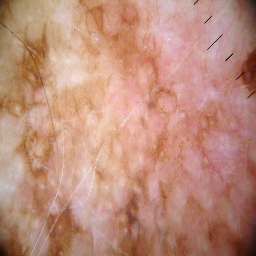

In [12]:
# Preview an image
array_to_img(train_images_fs[0])

Previewing one of the images form the test:

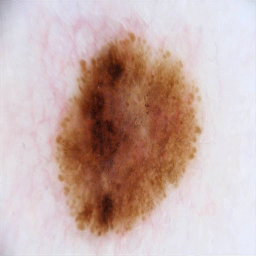

In [13]:
# Preview an image
array_to_img(test_images_fs[0])

Let us look at the shape of our data:

In [14]:
train_labels.shape

(2239, 9)

In [15]:
test_labels.shape

(118, 9)

This makes sense since we have 2239 images for the train and 118 for the test, and they are divided in 9 classes.

In [16]:
test_images_fs.shape

(118, 256, 256, 3)

In [17]:
train_images_fs.shape

(2239, 256, 256, 3)

Same number for the images of train and test, 256x256 is the size of the images, and the 3 is because it's 3 matrices, one for each color pixels RGB.
<br>Let us generate a dataframe to do some more EDA.

In [21]:
dataframe_train=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

Previewing the different classes and their labels:

In [22]:
dataframe_train

actinic_keratosis  basal_cell_carcinoma  dermatofibroma  melanoma  \
0                   0.0                   0.0             0.0       1.0   
1                   0.0                   1.0             0.0       0.0   
2                   0.0                   0.0             0.0       1.0   
3                   0.0                   0.0             0.0       0.0   
4                   0.0                   0.0             0.0       1.0   
...                 ...                   ...             ...       ...   
2234                0.0                   1.0             0.0       0.0   
2235                0.0                   0.0             0.0       0.0   
2236                0.0                   0.0             0.0       0.0   
2237                0.0                   1.0             0.0       0.0   
2238                0.0                   0.0             0.0       1.0   

      nevus  pigmented_benign_keratosis  seborrheic_keratosis  \
0       0.0                         0.0                   0.0   
1       0.0                         0.0                   0.0   
2       0.0                         0.0                   0.0   
3       0.0                         0.0                   0.0   
4       0.0                         0.0                   0.0   
...     ...                         ...                   ...   
2234    0.0                         0.0                   0.0   
2235    0.0                         0.0                   0.0   
2236    0.0                         0.0                   0.0   
2237    0.0                         0.0                   0.0   
2238    0.0                         0.0                   0.0   

      squamous_cell_carcinoma  vascular_lesion  
0                         0.0              0.0  
1                         0.0              0.0  
2                         0.0              0.0  
3                         1.0              0.0  
4                         0.0              0.0  
...                       ...              ...  
2234                      0.0              0.0  
2235                      0.0              1.0  
2236                      0.0              1.0  
2237                      0.0              0.0  
2238                      0.0              0.0  

[2239 rows x 9 columns]

Taking a look at the class indeces:

In [23]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

Next we are going to sum the instances for each class to get a sense of how many iamges we have per class:

In [198]:
sums=dataframe_train.sum(axis=0)
sums=pd.DataFrame(sums)
sums

0
actinic_keratosis           114.0
basal_cell_carcinoma        376.0
dermatofibroma               95.0
melanoma                    438.0
nevus                       357.0
pigmented_benign_keratosis  462.0
seborrheic_keratosis         77.0
squamous_cell_carcinoma     181.0
vascular_lesion             139.0

It seems that bening keratosis, melanoma and basal cell carcinoma are the most represented classes.
Class imbalance might be something to worry about, but that would be a concern mostly when we switch to a binary classification problem, with "benign" and "cancerous" classes.
<br>Converting the sum column into percentages.

In [223]:
sums['%'] = ((sums[0]/2239*100).round(2))
sums

0          %
actinic_keratosis           114.0   5.090000
basal_cell_carcinoma        376.0  16.790001
dermatofibroma               95.0   4.240000
melanoma                    438.0  19.559999
nevus                       357.0  15.940000
pigmented_benign_keratosis  462.0  20.629999
seborrheic_keratosis         77.0   3.440000
squamous_cell_carcinoma     181.0   8.080000
vascular_lesion             139.0   6.210000

In [211]:
sums['%']['nevus']

15.94

In [216]:
total_benign=np.sum([sums['%']['dermatofibroma'], sums['%']['pigmented_benign_keratosis'], 
                    sums['%']['nevus'], sums['%']['seborrheic_keratosis'], 
                    sums['%']['vascular_lesion']])
total_benign

50.459995

In [217]:
total_cancerous=np.sum([sums['%']['melanoma'], sums['%']['actinic_keratosis'], 
                    sums['%']['basal_cell_carcinoma'], sums['%']['squamous_cell_carcinoma']])
total_cancerous

49.520004

We can see that in terms of benign and cancerous, the classes are well balanced on the train set.

Showing in a histogram the distribution of the different images in the train set

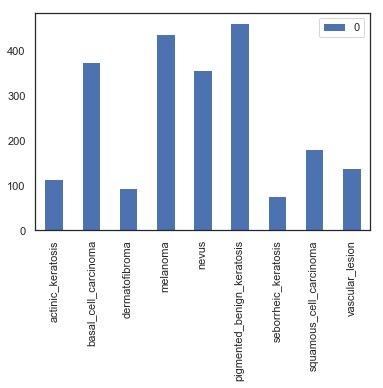

In [29]:
#Change this into seaborn to make it even cooler
sums.plot(kind='bar');

Repeating the same for the test set:

In [30]:
dataframe_test=pd.DataFrame(test_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])
sums_test=dataframe_test.sum(axis=0)
sums_test=pd.DataFrame(sums_test)

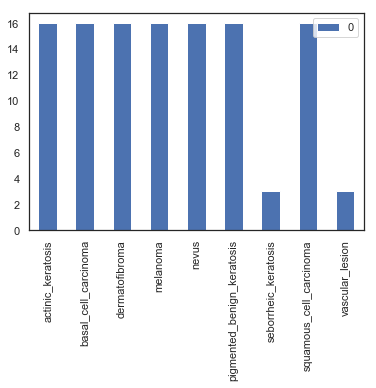

In [31]:
#Change this into seaborn to make it even cooler
sums_test.plot(kind='bar');

It seems like in the test the classes are more equally represented, except for seborrheic keratosis and vascular lesion.

In [218]:
sums_test['%'] = ((sums_test[0] / 118*100).round(2))
sums_test

0      %
actinic_keratosis           16.0  13.56
basal_cell_carcinoma        16.0  13.56
dermatofibroma              16.0  13.56
melanoma                    16.0  13.56
nevus                       16.0  13.56
pigmented_benign_keratosis  16.0  13.56
seborrheic_keratosis         3.0   2.54
squamous_cell_carcinoma     16.0  13.56
vascular_lesion              3.0   2.54

In [225]:
total_benign=np.sum([sums_test['%']['dermatofibroma'], 
                     sums_test['%']['pigmented_benign_keratosis'], 
                    sums_test['%']['nevus'], sums_test['%']['seborrheic_keratosis'], 
                    sums_test['%']['vascular_lesion']])
total_benign

45.760002

In [226]:
total_cancerous=np.sum([sums_test['%']['melanoma'], 
                        sums_test['%']['actinic_keratosis'], 
                    sums_test['%']['basal_cell_carcinoma'], 
                        sums_test['%']['squamous_cell_carcinoma']])
total_cancerous

54.24

For the test set, the percentage of malignant is 54% and bening is 46%.
Still a good balance between the two classes.
>BUT it could be a problem because the distribution between the classes is different, this might be what could bring a problem to the model that hasn't "learnt" how to identify specific classes, that are less present in the train and much more the test.
Namely acitinic keartosis and dermatofibroma.
List this as a possible cause of lower performance.

## Preprocessing

We are going to reimport our images with a lower resolution, since we want the models to be faster especially since we want to try a lot of them, then finally when we will run the final model and test it on the test we will use our best tuned model, retraining it on the full size images.

In [ ]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img8, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)

Exploring the shape of images and labels in our dataset:

In [227]:
# Explore your dataset
m_train = train_img8.shape[0]
num_px = train_img8.shape[1]
m_test = test_img8.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img8.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img8.shape))
print ("test_labels shape: " + str(test_lab.shape))

NameError: name 'test_img8' is not defined

Reshaping the labels into a format that can be fed to the model:

In [36]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

#### Building functions:

Building some functions that will help us visualize and compare the different models:

In [37]:
def visualize_training_results(results):
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Creating the empty dataframe where we will store the results:

In [38]:
# create an Empty DataFrame object
df = pd.DataFrame()

Because of the stochastic nature of Neural Networks, it is going to be hard to get consistent results.
What we can do to avoid this problem is to fit the model several times, and keep as a result the mean of the result.
Let us create a function to do that.

In [39]:
def statistic_results(model, trainX, trainy, epochs=20, batch=30):
    accu_train=[]
    accu_val=[]
    loss_train=[]
    loss_val=[]
    for i in range(10):
        resu=fit_model(model, trainX,
                    trainy, epo=epochs, batch=batch)
        accu_train.append(round(resu.history['acc'][-1],5))
        accu_val.append(round(resu.history['val_acc'][-1],5))
        loss_train.append(round(resu.history['loss'][-1],5))
        loss_val.append(round(resu.history['val_loss'][-1],5))
        i+=1
    mean_acc_train=np.mean(accu_train)
    mean_acc_val=np.mean(accu_val)
    mean_loss_train=np.mean(loss_train)
    mean_loss_val=np.mean(loss_val)
    std_at=np.std(accu_train)
    std_av=np.std(accu_val)
    std_lt=np.std(loss_train)
    std_lv=np.std(loss_val)
    return ({'Mean_accuracy_train': mean_acc_train, 
             'Mean_accuracy_validation': mean_acc_val, 
             'Mean_loss_train': mean_loss_train, 
             'Mean_loss_validation': mean_loss_val,
             'Std_acc_train': std_at,
             'Std_acc_val': std_av,
             'Std_loss_train': std_lt,
             'Std_loss_val': std_lv})    
                        

Next we are going to be creating a function to preview the results of our models.
<rb>With this function we will display the evolution of accuracy and loss in our model, during the different epochs.
<br>Below that we will see also the values of accuracy and loss and over time we will build a learning curve, adding the result of each previous model and the current one, to see if our model is improving.

In [40]:
def model_results(model, results, model_name, df, trainX, trainy ):
    visualize_training_results(results)
    stats=statistic_results(model, trainX, trainy)
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': stats['Mean_accuracy_train'] ,
        'accuracy validation': stats['Mean_accuracy_validation'],
        'loss train': stats['Mean_loss_train'],
        'loss validation': stats['Mean_loss_validation']})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

And one more function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too.

In [41]:
def fit_model(model, X, y, epo=15, batch=30, val_split=0.3, verbose=0):
    results = model.fit(X, y, epochs=epo, batch_size=batch, 
                        validation_split=val_split, verbose=verbose)
    return results

### Naive model

Let us take a look at the shape of our images, and reshape the labels so they can be fed into the model.

In [43]:
train_img8.shape

(2239, 8, 8, 3)

In [44]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

Creating a first basic model to keep as a reference point.

In [45]:
model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(8 ,8,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Fitting the model and getting results.

In [46]:
history = fit_model(model, train_img8,
                    train_y, epo=10, batch=10)

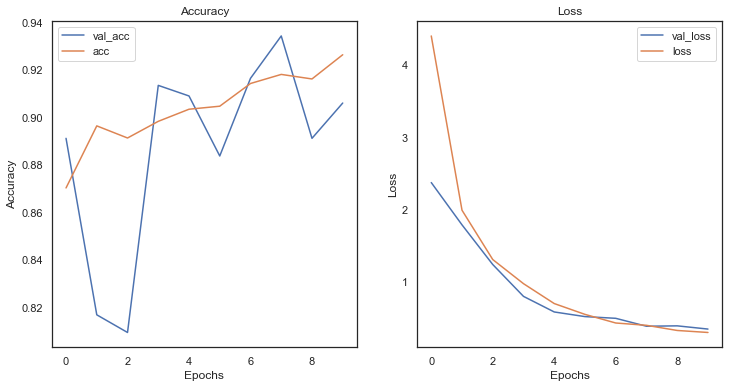

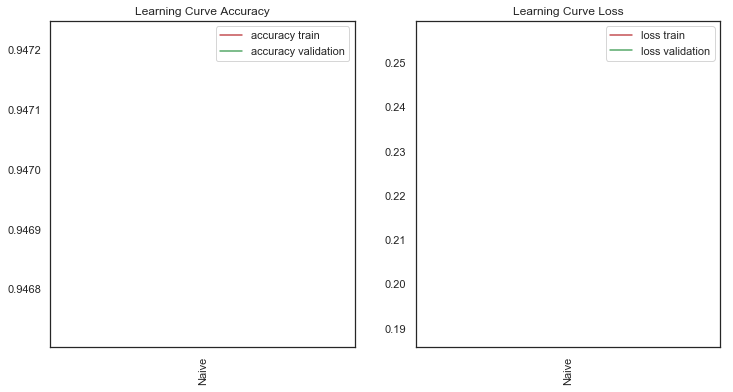

In [47]:
df=model_results(model, history, 'Naive', df, train_img8, train_y)

For now the bottom two graphs are empty because we have only 1 point in our learning curve for both loss and accuracy, but as we keep building models those visuals will be very helpful to see in which direction we are moving. 
<br>Calculating some statistics on our result with our designated function:

In [48]:
stats=statistic_results(model, train_img8,train_y)

In [49]:
stats

{'Mean_accuracy_train': 0.9467749999999999,
 'Mean_accuracy_validation': 0.946877,
 'Mean_loss_train': 0.18456899999999998,
 'Mean_loss_validation': 0.293665,
 'Std_acc_train': 0.0004221196512838649,
 'Std_acc_val': 0.0006828037785484162,
 'Std_loss_train': 0.014430699532593695,
 'Std_loss_val': 0.02853069022999619}

In [50]:
stats['Mean_accuracy_train']

0.9467749999999999

We can see that even our beginning naive model has already a pretty good accuracy. But we will take all the necessary steps to tune it and improve it. This is going to be helpful also if in the future we want to use this same model with a different dataset that doesn't necessarily have such good results from the start.


## Starting to improve our model:

#### To improve our model we will take several steps:
   - normalize the data 
   - increase image resolution
   - add more epochs
   - add more layers
   - increase the batch size
   - select the best optimization alogrithm
   - tune the optimization algorithm parameters (momentum and learning rate)
   - select best activation function
   - tune number of neurons in the layers
   
<br>After this, we will do another round of tuning for the model, this time using:
 - regularization
 - drop out layers

### Improving the model with 9 classes:

The first step to improve our model is to normalize the data.

#### Normalize the data:
As we have seen before the images are in the format of matrices that express the intensity of the color Red Green or Blue for each pixel.
The pixel values are expressed on a scale from 0 to 255, as we can see below:

In [53]:
train_img8[0][1]

array([[153., 131., 118.],
       [164., 142., 131.],
       [172., 145., 136.],
       [170., 133., 117.],
       [177., 152., 132.],
       [173., 157., 144.],
       [165., 135., 111.],
       [ 11.,  11.,  11.]], dtype=float32)

As we can see the RGB values of each pixel are not scaled, we are going to scale their value between 0 and 1 by dividing each pixel value by 225, which has proven usually helpful in increasing model performance.
To standardize the pixel values:

In [54]:
train_img8 /= 255.

In [55]:
train_img8[0][1]

array([[0.6       , 0.5137255 , 0.4627451 ],
       [0.6431373 , 0.5568628 , 0.5137255 ],
       [0.6745098 , 0.5686275 , 0.53333336],
       [0.6666667 , 0.52156866, 0.45882353],
       [0.69411767, 0.59607846, 0.5176471 ],
       [0.6784314 , 0.6156863 , 0.5647059 ],
       [0.64705884, 0.5294118 , 0.43529412],
       [0.04313726, 0.04313726, 0.04313726]], dtype=float32)

Now the pixels are expressed in values between 0 and 1.
<br>We move on to fit our model and preview the results.

In [56]:
history1 = fit_model(model, train_img8, train_y)

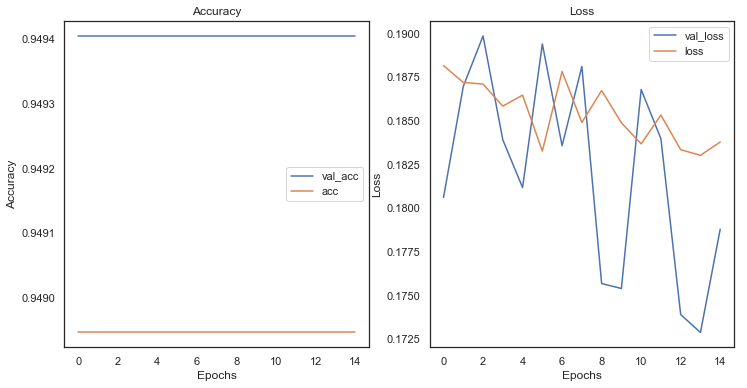

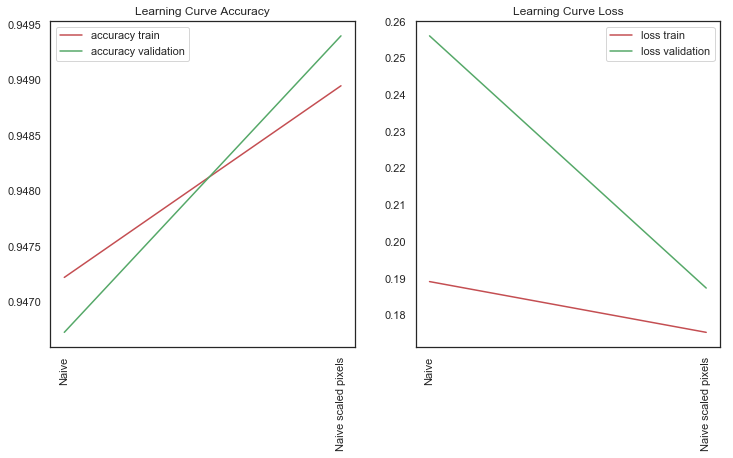

Name  accuracy train  accuracy validation  loss train  \
0                Naive        0.947223             0.946728    0.189128   
0  Naive scaled pixels        0.948950             0.949400    0.175292   

   loss validation  
0         0.256095  
0         0.187363

In [57]:
df=model_results(model, history1, 'Naive scaled pixels', df, train_img8, train_y)
df

> add comment about performance of the model after monitoring 3/4 days.
On day 1 the accuracy of both train and val went up, and  the loss of both train and validation went down.

#### Adding more layers and using higher resolution images:

Let us move on from the basic naive model to a more structured one with more layers.
<br>We will define it with a function that will allow us to also tweak other parameters, which is what we will do to keep tuning our model.
<br>With this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.
<br>We will also set most of these parameters as default, to make the execution of the function not too heavy.

In [58]:
def create_model(input_shape=(64, 64, 3), activation='relu', 
                 loss='sparse_categorical_crossentropy', 
                optimizer='rmsprop',metrics=['acc'] , 
                 neur1=10, neur2=20, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model

Let us import images with resolution 32x32, and create a model with more layers.

In [ ]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img32, train_lab = next(train_gen)
test_img32, test_lab = next(test_gen)

In [59]:
model_a=create_model(input_shape=(32,32,3))

In [60]:
history2 = fit_model(model_a, train_img32, train_y)

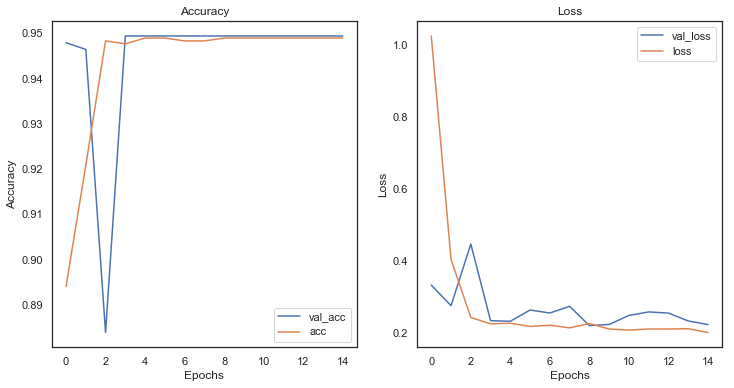

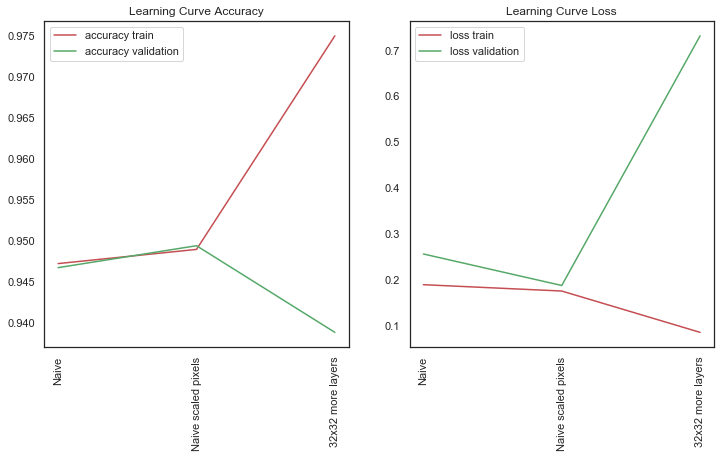

Name  accuracy train  accuracy validation  loss train  \
0                Naive        0.947223             0.946728    0.189128   
0  Naive scaled pixels        0.948950             0.949400    0.175292   
0    32x32 more layers        0.974983             0.938840    0.085165   

   loss validation  
0         0.256095  
0         0.187363  
0         0.731905

In [61]:
df=model_results(model_a, history2, '32x32 more layers', df, train_img32, train_y)
df

> add comments on the performance of the model
on Day 1:
accuracy of train went up to 975 but accuracy of validationwent down to 94. We start to see overfitting.
Confirmed by the fact that loss of train went down, but loss of accuracy went way up to 0.7

#### Increasing Image resolution:
Next to improve our model we will use images with a higher resolution to improve the performance.
Importing images with 64x64 image resolution:

In [233]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Create the datasets
train_img64, train_lab = next(train_gen)
test_img64, test_lab = next(test_gen)

#normalizing again
train_img64 /= 255.
test_img64 /= 255.

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [243]:
#Reshaping labels so they can be fed to the model
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

We need to create another model, since the input shape changed:

In [64]:
# No need to specify input shape, since the default is 64x64
model_b=create_model()

Fitting the model

In [65]:
history3 = fit_model(model_b, train_img64, train_y)

Let us visualize the results:

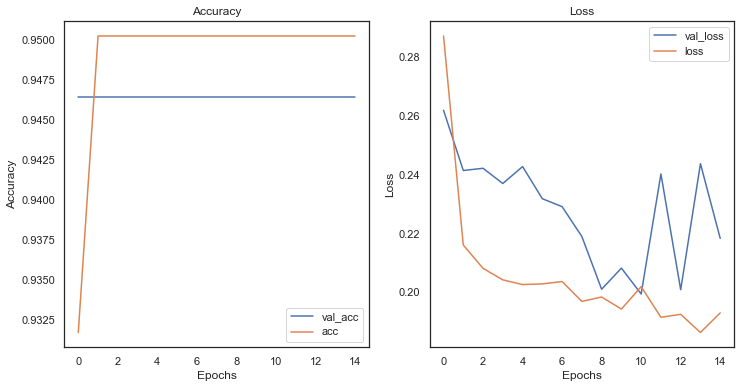

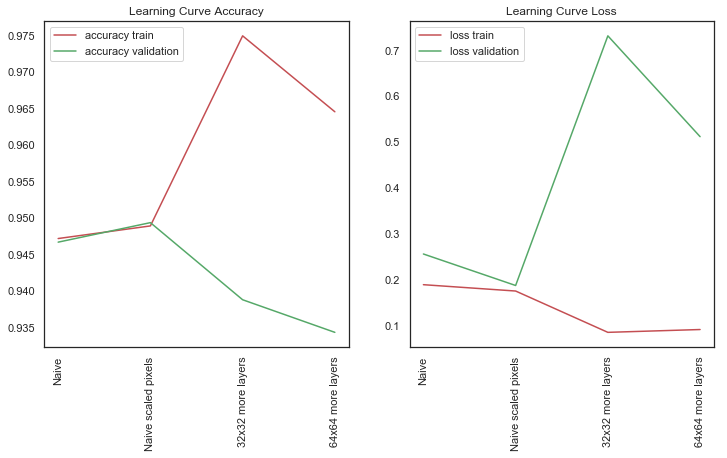

Name  accuracy train  accuracy validation  loss train  \
0                Naive        0.947223             0.946728    0.189128   
0  Naive scaled pixels        0.948950             0.949400    0.175292   
0    32x32 more layers        0.974983             0.938840    0.085165   
0    64x64 more layers        0.964583             0.934375    0.091323   

   loss validation  
0         0.256095  
0         0.187363  
0         0.731905  
0         0.511989

In [66]:
df=model_results(model_b, history3, '64x64 more layers', df,train_img64, train_y )
df

> Adding comments to the performance:
accuracy both train and val went down. But train still overfitting.
Loss of train and accuracy went down, still overfitting.

We tried also importing the images in their full size, and training the model on those but there was no substantial improvement in the performance, therefore we decided it was not worth the extra long computational time, and we did not include it.

Adding these images as the default in our `model_results` function since they'll be the ones we'll be using the most.

In [67]:
def model_results(model, results, model_name, df, trainX=train_img64, trainy=train_y ):
    visualize_training_results(results)
    stats=statistic_results(model, trainX, trainy)
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': stats['Mean_accuracy_train'] ,
        'accuracy validation': stats['Mean_accuracy_validation'],
        'loss train': stats['Mean_loss_train'],
        'loss validation': stats['Mean_loss_validation']})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

#### Increasing number of epochs:
Keeping the same model, but we run the model longer, for 30 epochs.

In [68]:
history4 = fit_model(model_b, train_img64, train_y, epo=30)

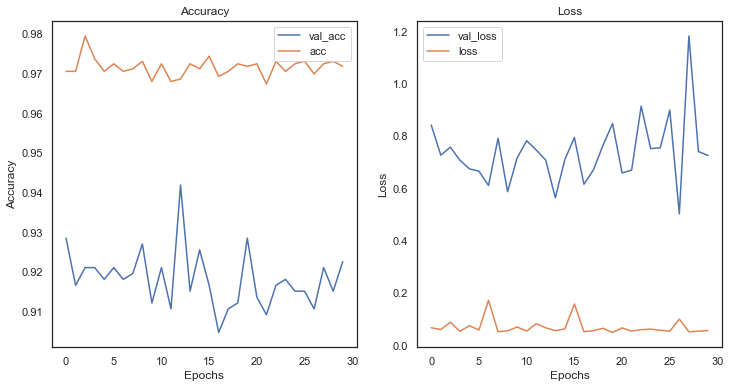

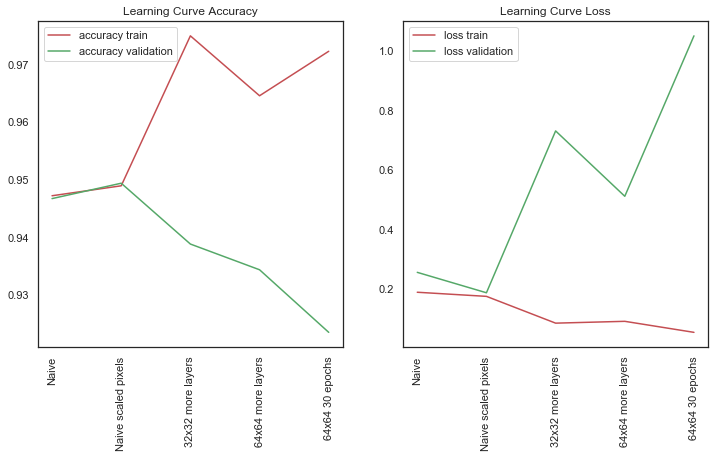

Name  accuracy train  accuracy validation  loss train  \
0                Naive        0.947223             0.946728    0.189128   
0  Naive scaled pixels        0.948950             0.949400    0.175292   
0    32x32 more layers        0.974983             0.938840    0.085165   
0    64x64 more layers        0.964583             0.934375    0.091323   
0      64x64 30 epochs        0.972304             0.923511    0.054213   

   loss validation  
0         0.256095  
0         0.187363  
0         0.731905  
0         0.511989  
0         1.051767

In [70]:
df=model_results(model_b, history4, '64x64 30 epochs', df)
df

> Comments on the performance:
accuracy train back up, accuracy val back down, even more overfitting.
Loss train slightly down, loss accuracy back up.
Still overfitting.

#### Increase the batch size: 50

This time we will increase the batch size, which is the group of pictures taken at a time by the model to work on.

In [71]:
history5 = fit_model(model_b, train_img64, train_y, epo=30, batch=50)

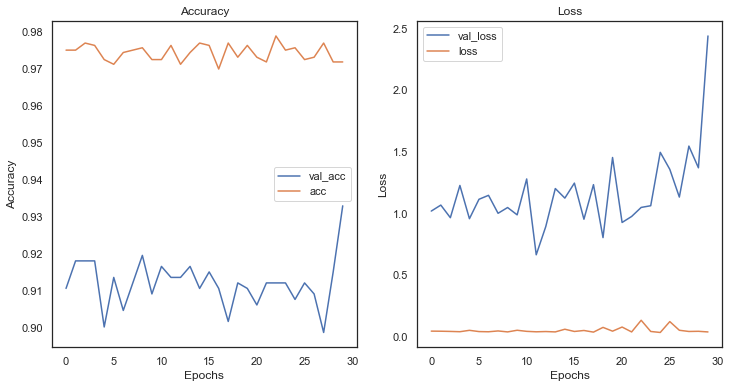

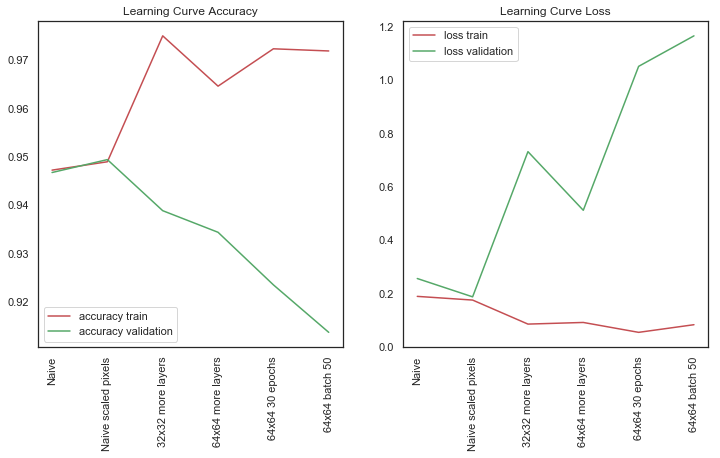

Name  accuracy train  accuracy validation  loss train  \
0                Naive        0.947223             0.946728    0.189128   
0  Naive scaled pixels        0.948950             0.949400    0.175292   
0    32x32 more layers        0.974983             0.938840    0.085165   
0    64x64 more layers        0.964583             0.934375    0.091323   
0      64x64 30 epochs        0.972304             0.923511    0.054213   
0       64x64 batch 50        0.971857             0.913691    0.082891   

   loss validation  
0         0.256095  
0         0.187363  
0         0.731905  
0         0.511989  
0         1.051767  
0         1.166199

In [72]:
df=model_results(model_b, history5, '64x64 batch 50', df)
df

> Comments on the performance: accuracy train stayed the same, accuracy val went even more down, still overfitting.
Loss train slightly up, loss validation way up.

The truth is that just getting one result for each of these attempts doesn't really tell us too much about the improvement or not of our model, because of the randomness of the results.
<br>What would be more appropriate is for each change we do (in the size of the images, the number of epochs, the batch size) to try a few different values to be able to really get a sense of in which direction our model is moving with that change.
<br>This would be very time consuming to do by hand, so the next step we are goign to take is building a grid search for these parameteres to get a better answer in terms of which ones are the optimal charateristic of our model, which gives us the best accuracy in determining the classification of the skin anomaly.

### Grid Search batch size and epochs:

Grid search is a model hyperparameter optimization technique.
In scikit learn this is a class, and when running a search with this class, we must input a dictionary of hyperparameters to evaluate in the param_grid argument. 
This dictionary contains the model parameter name and an array of values to try.

The GridSearchCV essentially builds and then evaluates one model for each combination of parameters. 
To evaluate each individual model, a 3-fold cross validation is used.

Once we  find out from the GridSearch what are the best parameteres we can use those (running just one single model) with higher resolution images.

Since GridSearch takes a long time to run, for this one and also the following ones we included the code but commented it out, so that it can be used again to run more grid searches also with different dataseta.
We are saving the parameteres that were identified by the search as the best ones (see below) so that the search doesn't need to be re run every time.

In [73]:
"""
# Use scikit-learn to grid search the batch size and epochs
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model())
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

'\n# Use scikit-learn to grid search the batch size and epochs\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n\n#set X and Y\nX=train_img64\nY=train_y\n# create model\nmodel = KerasClassifier(model=create_model())\n# define the grid search parameters\nbatch_size = [10, 20, 40, 60, 80, 100]\nepochs = [10, 50, 100]\nparam_grid = dict(batch_size=batch_size, epochs=epochs)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [74]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [75]:
#best_params=grid_result.best_params_
#best_params

In [76]:
#best_batch=best_params['batch_size']

Defining as `best_batch` the result from the grid search: 10.

In [77]:
best_batch=10

In [78]:
#best_epochs=best_params['epochs']

Defining as `best_epochs` the result form the grid search: also 10.

In [79]:
best_epochs=10

Now we can run again a model with the higher resolution images, using the best parameters we obtained from the grid search.

In [81]:
history6 = fit_model(model_b, train_img64, train_y, epo=best_epochs,
                    batch=best_batch)

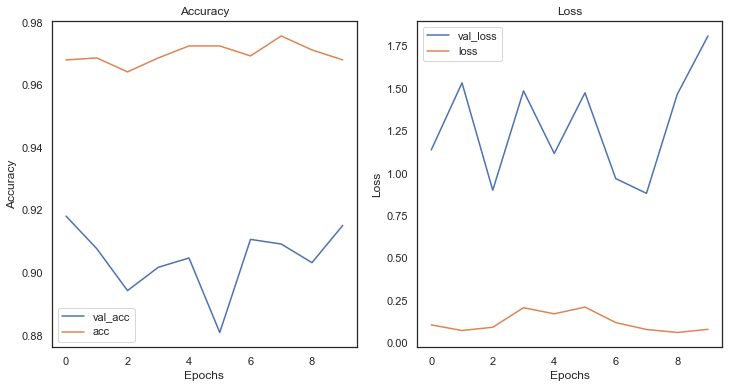

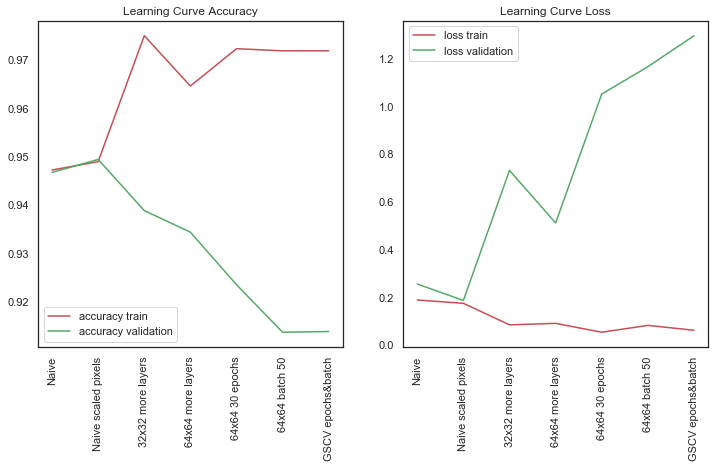

Name  accuracy train  accuracy validation  loss train  \
0                Naive        0.947223             0.946728    0.189128   
0  Naive scaled pixels        0.948950             0.949400    0.175292   
0    32x32 more layers        0.974983             0.938840    0.085165   
0    64x64 more layers        0.964583             0.934375    0.091323   
0      64x64 30 epochs        0.972304             0.923511    0.054213   
0       64x64 batch 50        0.971857             0.913691    0.082891   
0    GSCV epochs&batch        0.971858             0.913838    0.062537   

   loss validation  
0         0.256095  
0         0.187363  
0         0.731905  
0         0.511989  
0         1.051767  
0         1.166199  
0         1.296152

In [85]:
df=model_results(model_b, history6, 'GSCV epochs&batch', df)
df

> comment on the performance: accuracy train and validation stayed the same. Loss train went a bit down, loss validation went a bit up.

Changing the parameters in the definition of the function so I don't need to specify them again every time:

In [86]:
def statistic_results(model, trainX, trainy, epochs=best_epochs, batch=best_batch):
    accu_train=[]
    accu_val=[]
    loss_train=[]
    loss_val=[]
    for i in range(10):
        resu=fit_model(model, trainX,
                    trainy, epo=epochs, batch=batch)
        accu_train.append(round(resu.history['acc'][-1],5))
        accu_val.append(round(resu.history['val_acc'][-1],5))
        loss_train.append(round(resu.history['loss'][-1],5))
        loss_val.append(round(resu.history['val_loss'][-1],5))
        i+=1
    mean_acc_train=np.mean(accu_train)
    mean_acc_val=np.mean(accu_val)
    mean_loss_train=np.mean(loss_train)
    mean_loss_val=np.mean(loss_val)
    std_at=np.std(accu_train)
    std_av=np.std(accu_val)
    std_lt=np.std(loss_train)
    std_lv=np.std(loss_val)
    return ({'Mean_accuracy_train': mean_acc_train, 
             'Mean_accuracy_validation': mean_acc_val, 
             'Mean_loss_train': mean_loss_train, 
             'Mean_loss_validation': mean_loss_val,
             'Std_acc_train': std_at,
             'Std_acc_val': std_av,
             'Std_loss_train': std_lt,
             'Std_loss_val': std_lv})

### Grid Search Optimization Algorithm:

We can run again a GridSearch, but this time instead of trying different numbers of epochs and batch sizes, we will try different optimization algorithms. Here is a lists of them, and as we can see from the number of options, GridSearch is a good idea to shorten the time in trying all the different possible combinations:

- 'SGD'
- 'RMSprop'
- 'Adagrad'
- 'Adadelta'
- 'Adam' 
- 'Adamax' 
- 'Nadam'

The most popular and known ones are SGD, RMS prop and Adam.
RMS Prop is Root mean squared prop - it slows down learning in one direction and speeds it up in another one. On each iteration it uses exponentially weighted average of the squares of the derivatives.
SGD stands for Stochastic Gradient Descent - works like gradient descent but SGD randomly picks one data point from the whole data set at each iteration to reduce the computations enormously. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
Adam: adaptive moment estimation - combines the benefits of SGD and RMSProp. Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients.

We already have the function to create the model, and the X and Y we set before are the same. We just need to change the grid for the search of the parameters.

In [87]:
"""
# create model
model = KerasClassifier(model=create_model(), 
                        loss="sparse_categorical_crossentropy", 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


'\n# create model\nmodel = KerasClassifier(model=create_model(), \n                        loss="sparse_categorical_crossentropy", \n                        epochs=best_epochs, batch_size=best_batch)\n# define the grid search parameters\noptimizer = [\'SGD\', \'RMSprop\', \'Adagrad\', \'Adadelta\', \'Adam\', \'Adamax\', \'Nadam\']\nparam_grid = dict(optimizer=optimizer)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [88]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
"""

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n'

In [89]:
#best_params=grid_result.best_params_
#best_params

In [90]:
#best_opti=best_params['optimizer']
#best_opti

Defining as `best_opti` the parameter found by the grid search: sgd.

In [91]:
### Just for now let me add this so we don't have to redo the search
best_opti='sgd'

Creating a new model with the selected optimizer algorithm:

In [92]:
model_d=create_model(optimizer=best_opti)

In [93]:
history7 = fit_model(model_d, train_img64, train_y,
                    epo=best_epochs,
                    batch=best_batch)

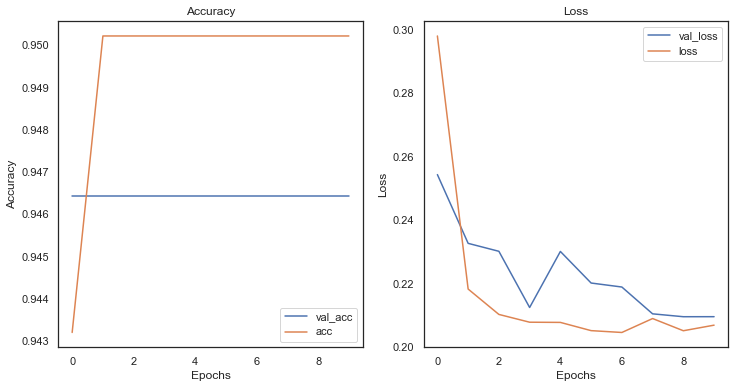

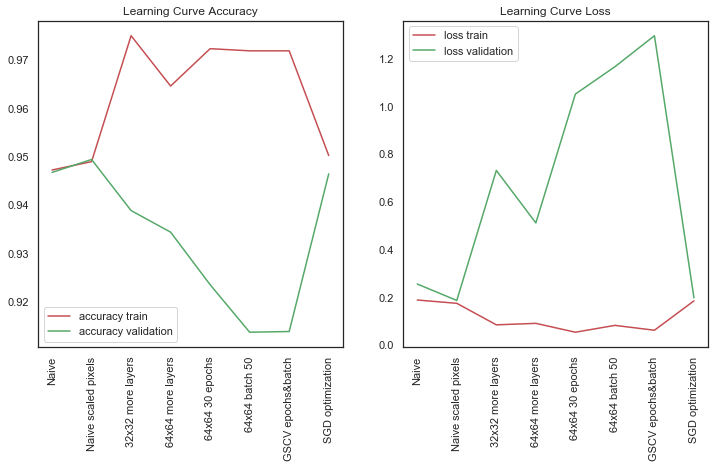

Name  accuracy train  accuracy validation  loss train  \
0                Naive        0.947223             0.946728    0.189128   
0  Naive scaled pixels        0.948950             0.949400    0.175292   
0    32x32 more layers        0.974983             0.938840    0.085165   
0    64x64 more layers        0.964583             0.934375    0.091323   
0      64x64 30 epochs        0.972304             0.923511    0.054213   
0       64x64 batch 50        0.971857             0.913691    0.082891   
0    GSCV epochs&batch        0.971858             0.913838    0.062537   
0     SGD optimization        0.950220             0.946430    0.185611   

   loss validation  
0         0.256095  
0         0.187363  
0         0.731905  
0         0.511989  
0         1.051767  
0         1.166199  
0         1.296152  
0         0.198297

In [94]:
df=model_results(model_d, history7, 'SGD optimization', df)
df

> Comment on the performance: accuracy train went down to 0.95 but accuracy val went way up to also almost 0.95 Muhc much less overfitting, confirmed also by the loss, which is almost the same for validation and train, 0.2.

### Grid Search Learning Rate and Momentum

Learning rate and momentum are parameters of the SGD optimization algorithm that we can tune.
The learning rate defines the entent to update the weight at the end of each batch, and the momentum defines how much to let the previous update influence the next weight update.

In [ ]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
"""

In [ ]:
"""
# create model
model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", 
                        optimizer="SGD", epochs=20, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

Let us print out just the best learning rate and momentum:

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [ ]:
#best_rate=best_params['optimizer__learning_rate']
#best_rate

In [95]:
best_rate=0.001

In [ ]:
#best_momentum=best_params['optimizer__momentum']
               

In [96]:
best_momentum=0.9

Next we will define the optimizer as SGC with the parameters selected by the Grid Search, and then create a model, fit it and preview the results.

In [97]:
optimizer = tf.keras.optimizers.SGD(learning_rate=best_rate, 
                                    momentum=best_momentum)

In [98]:
model_e=create_model(optimizer=optimizer)

In [99]:
history8= fit_model(model_e, train_img64, train_y,
                     epo=best_epochs,batch=best_batch)

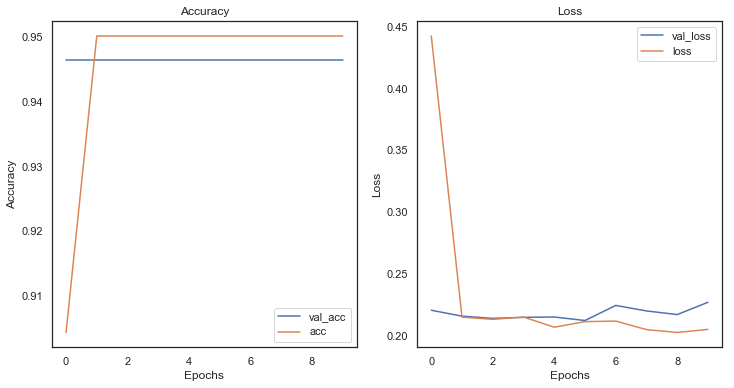

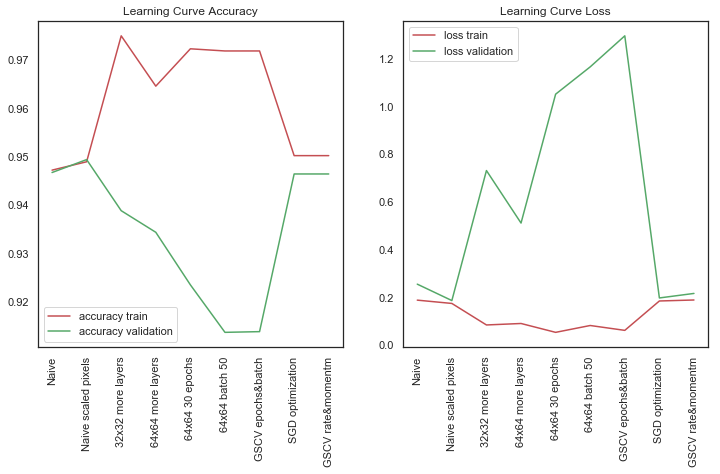

Name  accuracy train  accuracy validation  loss train  \
0                Naive        0.947223             0.946728    0.189128   
0  Naive scaled pixels        0.948950             0.949400    0.175292   
0    32x32 more layers        0.974983             0.938840    0.085165   
0    64x64 more layers        0.964583             0.934375    0.091323   
0      64x64 30 epochs        0.972304             0.923511    0.054213   
0       64x64 batch 50        0.971857             0.913691    0.082891   
0    GSCV epochs&batch        0.971858             0.913838    0.062537   
0     SGD optimization        0.950220             0.946430    0.185611   
0    GSCV rate&momentm        0.950220             0.946430    0.189738   

   loss validation  
0         0.256095  
0         0.187363  
0         0.731905  
0         0.511989  
0         1.051767  
0         1.166199  
0         1.296152  
0         0.198297  
0         0.217229

In [100]:
df=model_results(model_e, history8, 'GSCV rate&momentm', df)
df

> basically all the same

### How to Tune the Neuron Activation Function

#### Changing activation functions and optimizations:
Some of the options for activation functions are:
- relu
- swish
- softmax
- leaky relu
- sigmoid

The activation function is the one that translates the probability calculated by the model into the label of an actual class. An image might have a 60, 70 or 80% chance to belong to a class, which needs to be translated into the fact that the image belongs to that class, 1, or it doesn't, 0.
<br>For multiclass classifications the appropriate one is softmax, but we will tune the other ones for the previous layers of the model.

In [101]:
# Function to create model, required for KerasClassifier
def create_model_CV(activation):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(10, (3, 3), activation=activation,
                        input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(10, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(20, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

 # Compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                   optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
"""
# create model
model = KerasClassifier(model=create_model_CV, epochs=20, batch_size=20)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 
              'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

Best activation function is:

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [ ]:
#best_function=best_params['model__activation']
#best_function

Defining as `best_function` the function selected by the Grid Search: 'softmax'.

In [102]:
best_function='softmax'

Creating the model, fitting it and viewing results.

In [103]:
model_f=create_model(activation=best_function, optimizer=optimizer)

In [104]:
history9= fit_model(model_f, train_img64, train_y,
                     epo=best_epochs, batch=best_batch)

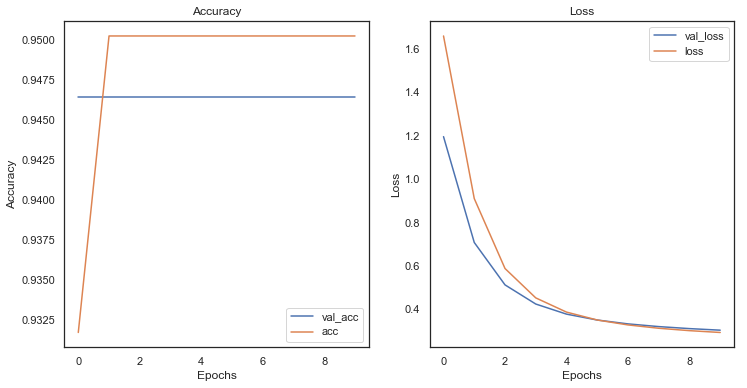

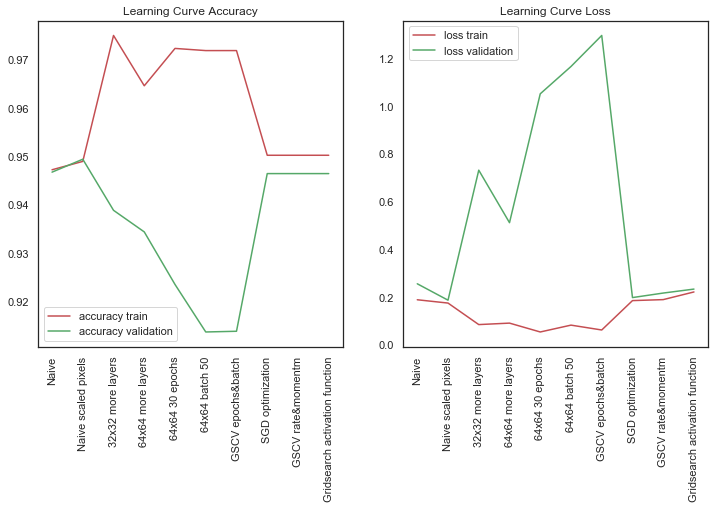

Name  accuracy train  accuracy validation  \
0                           Naive        0.947223             0.946728   
0             Naive scaled pixels        0.948950             0.949400   
0               32x32 more layers        0.974983             0.938840   
0               64x64 more layers        0.964583             0.934375   
0                 64x64 30 epochs        0.972304             0.923511   
0                  64x64 batch 50        0.971857             0.913691   
0               GSCV epochs&batch        0.971858             0.913838   
0                SGD optimization        0.950220             0.946430   
0               GSCV rate&momentm        0.950220             0.946430   
0  Gridsearch activation function        0.950220             0.946430   

   loss train  loss validation  
0    0.189128         0.256095  
0    0.175292         0.187363  
0    0.085165         0.731905  
0    0.091323         0.511989  
0    0.054213         1.051767  
0    0.082891         1.166199  
0    0.062537         1.296152  
0    0.185611         0.198297  
0    0.189738         0.217229  
0    0.221855         0.233843

In [105]:
df=model_results(model_f, history9, 'Gridsearch activation function', df)
df

> basically all the same, slightly higher loss for both val and train

### Grid Search number of neurons:

For this grid search we have to slightly modify our `create_model` function, since we are going to search 4 different numbers of neurons for each layer, there's no need to separate between the first 3 layers and the last one.

In [235]:
# Function to create model, required for KerasClassifier
def create_model_neurons(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation='softmax'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation='softmax'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='softmax'))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])
    return model

In [236]:
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y

In [237]:
#"""
# create model
model = KerasClassifier(model=create_model_neurons, epochs=30, batch_size=15, verbose=0)
# define the grid search parameters
neurons = [1, 2, 3, 5, 10, 15]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [238]:
#"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
 #   """

Best: 0.949084 using {'model__neurons': 1}
0.949084 (0.000032) with: {'model__neurons': 1}
0.949084 (0.000032) with: {'model__neurons': 2}
0.949084 (0.000032) with: {'model__neurons': 3}
0.949084 (0.000032) with: {'model__neurons': 5}
0.949084 (0.000032) with: {'model__neurons': 10}
0.949084 (0.000032) with: {'model__neurons': 15}


In [ ]:
#results=grid_result.best_params_
#results

In [ ]:
#neurons=results['model__neurons']
#neurons

model_neurons 1. Doesn't make sense. But it's also because all the results are the same. We will choose a standard value and pick 5.

In [239]:
best_neurons=5

In [109]:
model_g=create_model(activation=best_function, optimizer=optimizer,
                     neur1=best_neurons)

In [110]:
history10 = fit_model(model_g, train_img64,train_y,
                     epo=best_epochs,batch=best_batch)

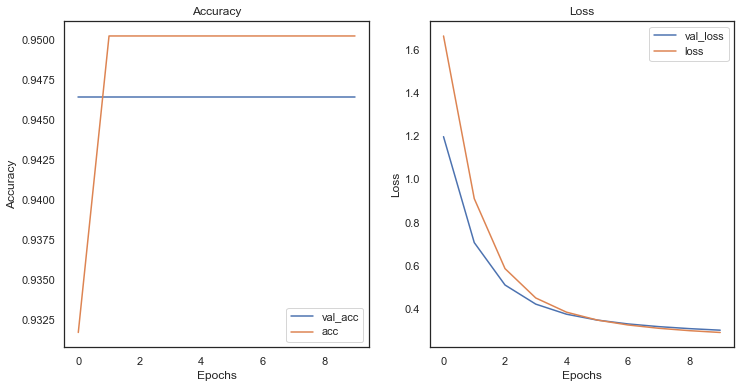

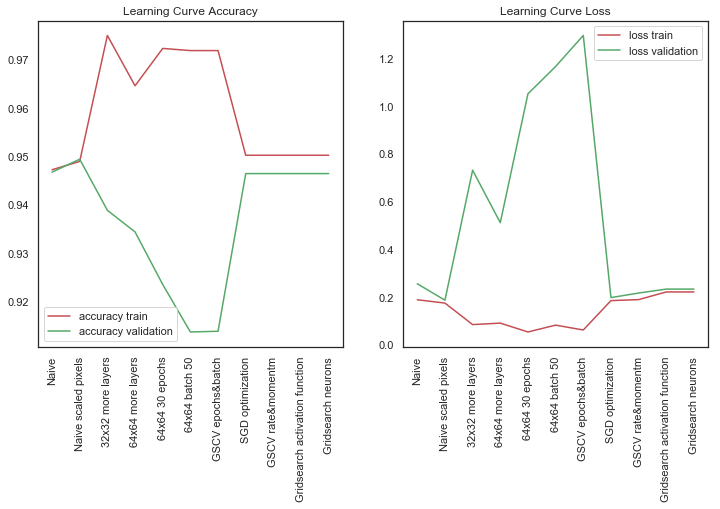

Name  accuracy train  accuracy validation  \
0                           Naive        0.947223             0.946728   
0             Naive scaled pixels        0.948950             0.949400   
0               32x32 more layers        0.974983             0.938840   
0               64x64 more layers        0.964583             0.934375   
0                 64x64 30 epochs        0.972304             0.923511   
0                  64x64 batch 50        0.971857             0.913691   
0               GSCV epochs&batch        0.971858             0.913838   
0                SGD optimization        0.950220             0.946430   
0               GSCV rate&momentm        0.950220             0.946430   
0  Gridsearch activation function        0.950220             0.946430   
0              Gridsearch neurons        0.950220             0.946430   

   loss train  loss validation  
0    0.189128         0.256095  
0    0.175292         0.187363  
0    0.085165         0.731905  
0    0.091323         0.511989  
0    0.054213         1.051767  
0    0.082891         1.166199  
0    0.062537         1.296152  
0    0.185611         0.198297  
0    0.189738         0.217229  
0    0.221855         0.233843  
0    0.221809         0.233797

In [111]:
df=model_results(model_g, history10, 'Gridsearch neurons', df)
df

> all the same, slightly higher loss for both 

## Tuning

Now that we selected all the best parameters for our model, there is some more tuning that we can do in particular to make sure that our model will not overfit the data.
This is achieved with regularization, dropout layers and early stopping.

### Regularization

Regularization is commonly used when the model is overfitting the data.
The main idea of regularization therefore is to penalize in some way a model that is too complex, that will tend to overfit the data.
L1 regularization just adds one parameter, is not commonly used in Neural Networks.
L2 on the other hand, also called "weigth decay", makes the weights smaller, penalizing especially the largest weights, in a way forcing the model to be simplified.

In [112]:
model_h = models.Sequential()
model_h.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax'))
model_h.add(layers.MaxPooling2D((2, 2)))
    
model_h.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax'
                         ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))
model_h.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax'
                          ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))

model_h.add(layers.Flatten())
model_h.add(layers.Dense(32, activation='softmax' 
                       ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.Dense(9, activation='softmax'))

# Compile model
model_h.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])


In [113]:
history11 = fit_model(model_h, train_img64,train_y, epo=best_epochs,batch=best_batch)

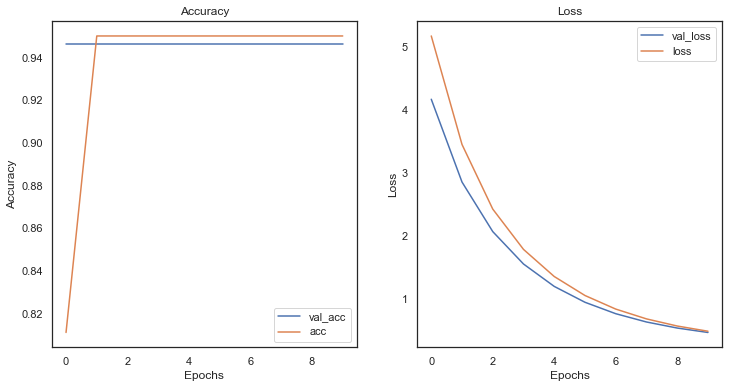

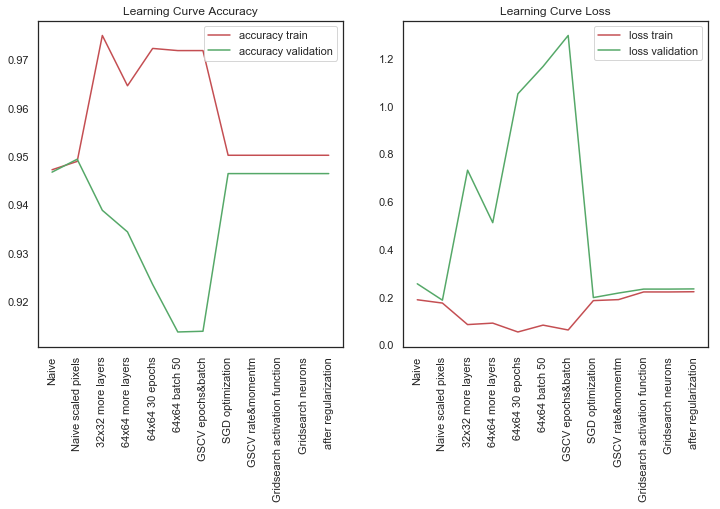

Name  accuracy train  accuracy validation  \
0                           Naive        0.947223             0.946728   
0             Naive scaled pixels        0.948950             0.949400   
0               32x32 more layers        0.974983             0.938840   
0               64x64 more layers        0.964583             0.934375   
0                 64x64 30 epochs        0.972304             0.923511   
0                  64x64 batch 50        0.971857             0.913691   
0               GSCV epochs&batch        0.971858             0.913838   
0                SGD optimization        0.950220             0.946430   
0               GSCV rate&momentm        0.950220             0.946430   
0  Gridsearch activation function        0.950220             0.946430   
0              Gridsearch neurons        0.950220             0.946430   
0            after regularization        0.950220             0.946430   

   loss train  loss validation  
0    0.189128         0.256095  
0    0.175292         0.187363  
0    0.085165         0.731905  
0    0.091323         0.511989  
0    0.054213         1.051767  
0    0.082891         1.166199  
0    0.062537         1.296152  
0    0.185611         0.198297  
0    0.189738         0.217229  
0    0.221855         0.233843  
0    0.221809         0.233797  
0    0.222758         0.234607

In [114]:
df=model_results(model_h, history11, 'after regularization', df)
df

> same

We tried also regularization paramteres L2=0.005, L2=0.01, but the best value turned out to be L2=0.05, and we have not included the other ones for brevity.

### Dropout Regularization

Dropout layers, forces the model to block out some nodes, for the model to not rely heavily on certain paths.

In [240]:
# Function to create model, required for KerasClassifier
def create_model_drop(dropout_rate, weight_constraint):

    model = models.Sequential()
    model.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
    model.add(layers.Dropout(dropout_rate))
            

    model.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
    model.add(layers.Dropout(dropout_rate))            

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
    return model

In [241]:
#"""
# create model
model = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, 
                  model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""

Epoch 1/30
112/112 [==============================] - 8s 63ms/step - loss: 5.1559 - acc: 0.4631
Epoch 2/30
112/112 [==============================] - 7s 66ms/step - loss: 3.7982 - acc: 0.9560
Epoch 3/30
112/112 [==============================] - 8s 68ms/step - loss: 2.8347 - acc: 0.9561
Epoch 4/30
112/112 [==============================] - 8s 70ms/step - loss: 2.2168 - acc: 0.9450
Epoch 5/30
112/112 [==============================] - 8s 69ms/step - loss: 1.7450 - acc: 0.9560
Epoch 6/30
112/112 [==============================] - 8s 70ms/step - loss: 1.4398 - acc: 0.9488
Epoch 7/30
112/112 [==============================] - 8s 70ms/step - loss: 1.1799 - acc: 0.9532
Epoch 8/30
112/112 [==============================] - 7s 61ms/step - loss: 0.9923 - acc: 0.9523
Epoch 9/30
112/112 [==============================] - 7s 62ms/step - loss: 0.8656 - acc: 0.9457
Epoch 10/30
112/112 [==============================] - 7s 60ms/step - loss: 0.7652 - acc: 0.9409
Epoch 11/30
112/112 [==================

In [242]:
#"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))#    """

Best: 0.949084 using {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 4.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.3, 'model__weight_constraint': 1.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.3, 'model__weight_constraint': 2.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.3, 'model__weight_constraint': 3.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.3, 'model__weight_constraint': 4.0}
0.949084 (0.000032) with: {'model__dropout_rate': 0.3, 'model__weight_constraint': 5.0}
0.949084 (0.000032) with: {'model__dr

In [244]:
best_params=grid_result.best_params_
best_params

{'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}

In [ ]:
#best_drop=best_params['model__dropout_rate']
#best_drop

In [116]:
best_drop=0.5

In [117]:
#best_weight_const=best_params['model__weight_constraint']

In [118]:
best_weight_const=3.0

Now that it is clear from the grid search what is the best drop out rate let us create our model with it and see the results in comparison to the other models.

In [119]:
model_i = models.Sequential()
model_i.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
model_i.add(layers.MaxPooling2D((2, 2)))
    
model_i.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_i.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model_i.add(layers.Dropout(best_drop))
            
model_i.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_i.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model_i.add(layers.Dropout(best_drop))            

model_i.add(layers.Flatten())
model_i.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model_i.add(layers.Dense(9, activation='softmax'))

# Compile model
model_i.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

# Compile model
model_i.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
              

In [120]:
history12 = fit_model(model_i, train_img64,train_y,
                     epo=best_epochs,batch=best_batch)

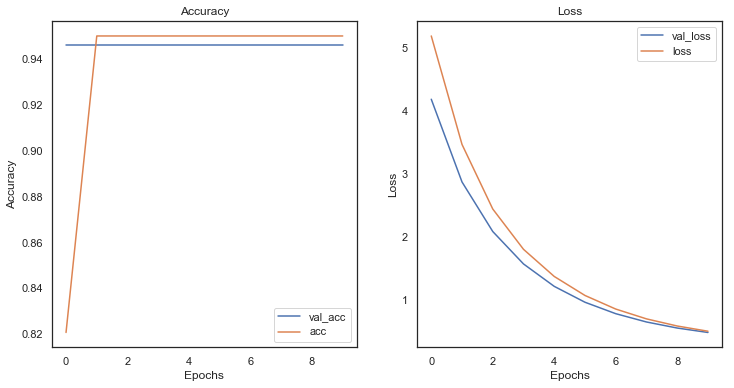

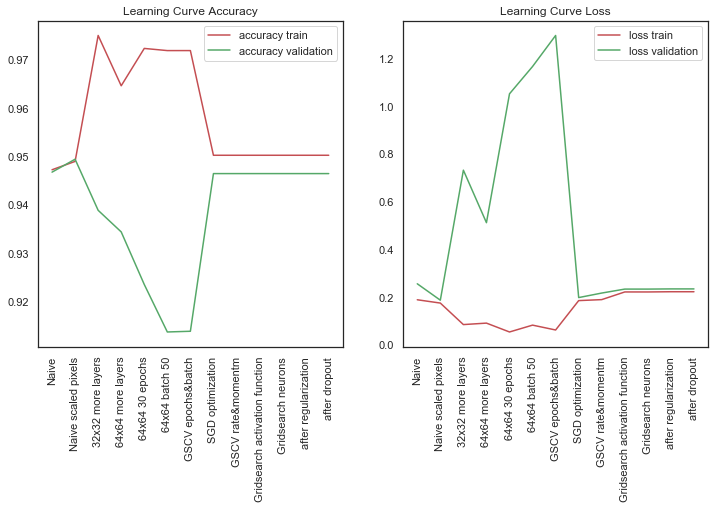

Name  accuracy train  accuracy validation  \
0                           Naive        0.947223             0.946728   
0             Naive scaled pixels        0.948950             0.949400   
0               32x32 more layers        0.974983             0.938840   
0               64x64 more layers        0.964583             0.934375   
0                 64x64 30 epochs        0.972304             0.923511   
0                  64x64 batch 50        0.971857             0.913691   
0               GSCV epochs&batch        0.971858             0.913838   
0                SGD optimization        0.950220             0.946430   
0               GSCV rate&momentm        0.950220             0.946430   
0  Gridsearch activation function        0.950220             0.946430   
0              Gridsearch neurons        0.950220             0.946430   
0            after regularization        0.950220             0.946430   
0                   after dropout        0.950220             0.946430   

   loss train  loss validation  
0    0.189128         0.256095  
0    0.175292         0.187363  
0    0.085165         0.731905  
0    0.091323         0.511989  
0    0.054213         1.051767  
0    0.082891         1.166199  
0    0.062537         1.296152  
0    0.185611         0.198297  
0    0.189738         0.217229  
0    0.221855         0.233843  
0    0.221809         0.233797  
0    0.222758         0.234607  
0    0.222740         0.234593

In [121]:
df=model_results(model_i, history12, 'after dropout', df)
df

> same

### Best model

> This final i model, explain a bit your choice.

### Evaluate the model:

To evaluate the train we will calculate the loss and accuracy, both on the train and on the test set, which so far we haven't touched, it is therefore unseen data.

#### On the train:

In [122]:
train_loss, train_acc = model_i.evaluate(train_img64, train_y)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

70/70 [==============================] - 2s 23ms/step - loss: 0.2115 - acc: 0.9491
Train Loss: 0.2114732563495636 
Train Accuracy: 0.9490844011306763


#### On the test:

In [123]:
test_loss, test_acc= model_i.evaluate(test_img64, test_y)

print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

4/4 [==============================] - 0s 22ms/step - loss: 0.4701 - acc: 0.8644
Test Loss: 0.4701172113418579 
Test Accuracy: 0.8644067645072937


#### Doing it again with 256x256 images:

In [124]:
#normalizing again
train_images_fs /= 255.
test_images_fs /= 255.

In [ ]:
"""
#Creating same model but with input shape 256x256
model_j = models.Sequential()
model_j.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(256, 256, 3)))
model_j.add(layers.MaxPooling2D((2, 2)))
    
model_j.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_j.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model_j.add(layers.Dropout(best_drop))
            
model_j.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_j.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model_j.add(layers.Dropout(best_drop))            

model_j.add(layers.Flatten())
model_j.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model_j.add(layers.Dense(9, activation='softmax'))

# Compile model
model_j.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
              """

In [ ]:
# takes a long time!
###model_j.fit(train_images_fs, train_y,  epochs=best_epochs,
###                batch_size=best_batch)
#callbacks=early_stopping) Figure out if you want to include this

In [ ]:
#train_loss, train_acc = model_j.evaluate(train_images_fs, train_y)

#print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

In [ ]:
#test_loss, test_acc= model_j.evaluate(test_images_fs, test_y)

#print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

## Changing to two classes cancerous and bening

Next I will work on the data, creating a separate folder 'binary' in which I will store the images divided into 2 classes instead of 9, 'benign' and 'cancerous'.
<br>This folder will still have the same division into train and test that the original data has.
<br>Some of the code below is commented out as we wanted to create the directory and copy the images only once, and not every time that the notebook is compiled, but a user that would want to do the same can uncomment and proceed with the code as is to create the same directories and subfolders.

#### Train Set:

In [ ]:
acti_dir = 'dataskin/Train/actinic keratosis'
basal_dir = 'dataskin/Train/basal cell carcinoma'
derma_dir = 'dataskin/Train/dermatofibroma'
mela_dir = 'dataskin/Train/melanoma'
nevus_dir = 'dataskin/Train/nevus'
pigm_dir = 'dataskin/Train/pigmented benign keratosis'
sebo_dir = 'dataskin/Train/seborrheic keratosis'
squa_dir = 'dataskin/Train/squamous cell carcinoma'
lesion_dir = 'dataskin/Train/vascular lesion'

new_dir = 'dataskin/binary/'

In [ ]:
imgs_acti = [file for file in os.listdir(acti_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images of actinic keratosis')
imgs_basal = [file for file in os.listdir(basal_dir) if file.endswith('.jpg')]
print('There are', len(imgs_basal), 'images of basal cell carcinoma')
imgs_mela = [file for file in os.listdir(mela_dir) if file.endswith('.jpg')]
print('There are', len(imgs_mela), 'images of melanoma')
imgs_squa = [file for file in os.listdir(squa_dir) if file.endswith('.jpg')]
print('There are', len(imgs_squa), 'images of squamous cell carcinoma')

imgs_derma = [file for file in os.listdir(derma_dir) if file.endswith('.jpg')]
print('There are', len(imgs_derma), 'images of dermatofibroma')
imgs_nevus = [file for file in os.listdir(nevus_dir) if file.endswith('.jpg')]
print('There are', len(imgs_nevus), 'images of nevus')
imgs_pigm = [file for file in os.listdir(pigm_dir) if file.endswith('.jpg')]
print('There are', len(imgs_pigm), 'images of pigmented benign keratosis')
imgs_sebo = [file for file in os.listdir(sebo_dir) if file.endswith('.jpg')]
print('There are', len(imgs_sebo), 'images of seborrheic keratosis')
imgs_lesion = [file for file in os.listdir(lesion_dir) if file.endswith('.jpg')]
#print('There are', len(imgs_lesion), 'images of vascula lesion')

In [ ]:
# Code to create the new doler 'binary'
#os.mkdir(new_dir)

In [ ]:
""" Code to create paths to subfolders
train_folder = os.path.join(new_dir, 'train')
train_benign = os.path.join(train_folder, 'benign')
train_cancerous = os.path.join(train_folder, 'cancerous')

test_folder = os.path.join(new_dir, 'test')
test_benign = os.path.join(test_folder, 'benign')
test_cancerous = os.path.join(test_folder, 'cancerous')
"""

In [ ]:
""" Code to create subfolders

os.mkdir(train_folder)
os.mkdir(train_benign)
os.mkdir(train_cancerous)

os.mkdir(test_folder)
os.mkdir(test_benign)
os.mkdir(test_cancerous)
"""

We have to split the classes between benign and cancerou, so recall:
<br>Actinic keratosis, basal cell carcinoma, melanoma and squamous cell carcinoma are cancerous.
<br>Dermatofibroma, pigmented benign keratosis, nevus, seborrheic keratosis and vascular lesions are benign.
<br>As totals we except:

In [ ]:
total_benign=len(imgs_derma)+len(imgs_nevus)+len(imgs_pigm)+len(imgs_sebo)+len(imgs_lesion)
total_cancerous=len(imgs_acti)+len(imgs_basal)+len(imgs_mela)+len(imgs_squa)
print(f'total bening {total_benign}, total cancerous {total_cancerous}')

In [ ]:
""" Code to copy images from dermatofibroma into new folder 'benign'
# train benign
imgs = imgs_derma
for img in imgs:
    origin = os.path.join(derma_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
    """

Now let us repeat that for all the other benign classes:

In [ ]:
""" Code to copy images from 4 folders into new folder 'benign'
imgs = imgs_nevus
for img in imgs:
    origin = os.path.join(nevus_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_pigm
for img in imgs:
    origin = os.path.join(pigm_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_sebo
for img in imgs:
    origin = os.path.join(sebo_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_lesion
for img in imgs:
    origin = os.path.join(lesion_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
    """ 

In [ ]:
train_benign_dir = 'dataskin/binary/train/benign'

imgs_acti = [file for file in os.listdir(train_benign_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images in train benign')

Moving on to the cancerous class:

In [ ]:
""" Code to copy images from 4 folders into new folder 'cancerous'
#train cancerous
imgs = imgs_acti
for img in imgs:
    origin = os.path.join(acti_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_basal
for img in imgs:
    origin = os.path.join(basal_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_mela
for img in imgs:
    origin = os.path.join(mela_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_squa
for img in imgs:
    origin = os.path.join(squa_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
    """

In [ ]:
train_can_dir = 'dataskin/binary/train/cancerous'

imgs_acti = [file for file in os.listdir(train_can_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images in train cancerous')

#### Test Set:
Now I just need to repeat the same steps for the test:

In [ ]:
acti_dir = 'dataskin/Test/actinic keratosis'
basal_dir = 'dataskin/Test/basal cell carcinoma'
derma_dir = 'dataskin/Test/dermatofibroma'
mela_dir = 'dataskin/Test/melanoma'
nevus_dir = 'dataskin/Test/nevus'
pigm_dir = 'dataskin/Test/pigmented benign keratosis'
sebo_dir = 'dataskin/Test/seborrheic keratosis'
squa_dir = 'dataskin/Test/squamous cell carcinoma'
lesion_dir = 'dataskin/Test/vascular lesion'

In [ ]:
imgs_acti = [file for file in os.listdir(acti_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images of actinic keratosis')
imgs_basal = [file for file in os.listdir(basal_dir) if file.endswith('.jpg')]
print('There are', len(imgs_basal), 'images of basal cell carcinoma')
imgs_mela = [file for file in os.listdir(mela_dir) if file.endswith('.jpg')]
print('There are', len(imgs_mela), 'images of melanoma')
imgs_squa = [file for file in os.listdir(squa_dir) if file.endswith('.jpg')]
print('There are', len(imgs_squa), 'images of squamous cell carcinoma')

imgs_derma = [file for file in os.listdir(derma_dir) if file.endswith('.jpg')]
print('There are', len(imgs_derma), 'images of dermatofibroma')
imgs_nevus = [file for file in os.listdir(nevus_dir) if file.endswith('.jpg')]
print('There are', len(imgs_nevus), 'images of nevus')
imgs_pigm = [file for file in os.listdir(pigm_dir) if file.endswith('.jpg')]
print('There are', len(imgs_pigm), 'images of pigmented benign keratosis')
imgs_sebo = [file for file in os.listdir(sebo_dir) if file.endswith('.jpg')]
print('There are', len(imgs_sebo), 'images of seborrheic keratosis')
imgs_lesion = [file for file in os.listdir(lesion_dir) if file.endswith('.jpg')]
print('There are', len(imgs_lesion), 'images of vascula lesion')

In [ ]:
total_benign=len(imgs_derma)+len(imgs_nevus)+len(imgs_pigm)+len(imgs_sebo)+len(imgs_lesion)
total_cancerous=len(imgs_acti)+len(imgs_basal)+len(imgs_mela)+len(imgs_squa)
print(f'total bening {total_benign}, total cancerous {total_cancerous}')

In [ ]:
""" Code to copy images from 5 folders into new folder 'benign'
# test benign
imgs = imgs_derma
for img in imgs:
    origin = os.path.join(derma_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_nevus
for img in imgs:
    origin = os.path.join(nevus_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_pigm
for img in imgs:
    origin = os.path.join(pigm_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_sebo
for img in imgs:
    origin = os.path.join(sebo_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_lesion
for img in imgs:
    origin = os.path.join(lesion_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
    """

In [ ]:
test_benign_dir = 'dataskin/binary/test/benign'

imgs_test = [file for file in os.listdir(test_benign_dir) if file.endswith('.jpg')]
print('There are', len(imgs_test), 'images in test benign')

In [ ]:
""" Code to copy images from 4 folders into new folder 'cancerous'
#test cancerous
imgs = imgs_acti
for img in imgs:
    origin = os.path.join(acti_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_basal
for img in imgs:
    origin = os.path.join(basal_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_mela
for img in imgs:
    origin = os.path.join(mela_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_squa
for img in imgs:
    origin = os.path.join(squa_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
"""

In [ ]:
test_can_dir = 'dataskin/binary/test/cancerous'

imgs_acti = [file for file in os.listdir(test_can_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images in test cancerous')

#### In the case of class imbalance:

If there was an imbalance between the classes we could balance them using augmentation, which consists in generating more data from the images we already have.
<br>If for example we had many more images of bening growths, we could generate more images form the ones we have of cancerous growths.
<br>This technique allows to rotate, shift, zoom and filp an image, to generate a slightly different one form the original, to be included in the data used to train our model.
<br>We include here the code to do so, if a user wanted to try this out, especially if, using a different dataset that was to be imbalanced, one wanted to balance it out.

In [ ]:
"""
# If there is an imbalance re balance the classes with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=True)

#to preview an example
names = [os.path.join(train_benign, name) for name in os.listdir(train_benign)]
img_path = names[91]
img = load_img(img_path, target_size=(64, 64))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()
"""

### New Metrics: Recall and F1 score

Now that we have defined the problem in a different way, having two classes and therefore making it a binary problem, we can define and use differnt metrics to evaluate our models.
<br>In particular a metric that is ver widely used in the medical field is recall, which tells us what percentage of the classes we are interested in were actually captured by the model.
<br>It is calculated as number of true positives identified by the model (true positive means the sample belonged to a class and we identified it correctly as belonging to that class) divided by the number of actual total positives (all the samples belonging to that class. It gives us a sense of how many cases we identified correctly in a class compared to the total of that class.
What brings down the recall is the number of positives that were not identified, called false negatives. In our case it would be when a skin anomaly was classified as bening, when it is actually cancerous.
<br>We want to obviously minimize these instances, even if it means the overall precision of the model is lower, we would rather identify more cancerous cases (even if some will turn out to be actually benign) rather than the other way wround, leaving untreated a patient that has a cancerous skin growth.
<br>At the same time we do not want our model to become overall very imprecise, the risk with high recall for the model is to identify all the cases as cancerous, which would leave us with no false negatives but with also very little accuracy of the model overall. This is when another metric F1 comes in handy.
<br>F1 is the harmonic mean of precision and recall.
<br>We will keep an eye on F1 which gives us an overall sense of the performance of the model (to make sure we are not getting an amazing recall while all the other metrics are plummeting) and we will keep looking at accuracy and loss as we have done before.

Let us define a few new functions to introduce these metrics and keep track of them:

In [125]:
def calculate_metrics(model, trainX=train_img64, trainy=train_y, epochs=20, batch=30):
    recs=[]
    f1s=[]
    for i in range(10):
        fit_model(model, trainX, trainy, epo=epochs, batch=batch)
    # predict probabilities
        y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
#    y_pred_clas = (model.predict(trainX) > 0.5).astype("int32")
        y_pred_clas = np.argmax(y_pred_prob,axis=1)
#    y_pred_clas =np.round(y_pred_prob).astype(int)
    # reduce to 1d array
        y_pred_prob = y_pred_prob[:, 0]
#        y_pred_clas = y_pred_clas[:, 0]
        recall = recall_score(trainy, y_pred_clas)
        f1 = f1_score(trainy, y_pred_clas)
        recs.append(recall)
        f1s.append(f1)
        i+=1
    recall_mean=np.mean(recs)
    f1_mean=np.mean(f1s)
        
    return recall_mean, f1_mean

In [126]:
def confusion_matrix(model, trainX, trainy):
    y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
#    y_pred_clas = (model.predict(trainX) > 0.5).astype("int32")
    y_pred_clas = np.argmax(y_pred_prob,axis=1)
#    y_pred_clas =np.round(y_pred_prob).astype(int)
    # confusion matrix
    cnm = confusion_matrix(trainy, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Greens")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [127]:
def model_results_bin(model, results, model_name, df, trainX=train_img64, trainy=train_y):
    visualize_training_results(results)
    recall, f1=calculate_metrics(model, trainX, trainy)
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': [round(results.history['acc'][-1],5)] ,
        'accuracy validation': [round(results.history['val_acc'][-1],5 )],
        'loss train': [round(results.history['loss'][-1],5)],
        'loss validation': [round(results.history['val_loss'][-1],5)],
        'recall': [recall] ,
        'f1': [f1]                      
                       })
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()
    plt.show()
    
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['recall']
    plt.plot(x, y, color='cyan')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Recall')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['f1']
    plt.plot(x, y, color='purple')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve F1')
    plt.legend()

    plt.show()
    
    return df

### Importing again images, divided in two classes instead of 9:

In [128]:
# Directory path
train_data_dir = 'dataskin/binary/train'
test_data_dir = 'dataskin/binary/test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Create the datasets
train_img64, train_lab = next(train_gen)
test_img64, test_lab = next(test_gen)

train_img64 /= 255.
test_img64 /= 255.

Found 118 images belonging to 2 classes.
Found 2239 images belonging to 2 classes.


In [129]:
train_gen.class_indices 

{'benign': 0, 'cancerous': 1}

In [130]:
# Explore your dataset again
m_train = train_img64.shape[0]
num_px = train_img64.shape[1]
m_test = test_img64.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img64.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img64.shape))
print ("test_labels shape: " + str(test_lab.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 64, 64, 3)
train_labels shape: (2239, 2)
test_images shape: (118, 64, 64, 3)
test_labels shape: (118, 2)


Reshape the train:

In [131]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

#### Naive Model:

In [132]:
naive_model = models.Sequential()
naive_model.add(layers.Conv2D(3, (3, 3), activation='sigmoid',
                        input_shape=(64 ,64,  3)))
naive_model.add(layers.MaxPooling2D((2, 2)))

naive_model.add(layers.Flatten())
naive_model.add(layers.Dense(1, activation='sigmoid'))

naive_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [133]:
df=pd.DataFrame()

In [134]:
naive_hist = fit_model(naive_model, train_img64, train_y , val_split=0.3, verbose=1)

Epoch 1/15
53/53 [==============================] - 2s 28ms/step - loss: 0.8361 - acc: 0.4571 - val_loss: 0.7475 - val_acc: 0.5238
Epoch 2/15
53/53 [==============================] - 1s 25ms/step - loss: 0.7305 - acc: 0.4957 - val_loss: 0.6928 - val_acc: 0.5179
Epoch 3/15
53/53 [==============================] - 1s 24ms/step - loss: 0.7026 - acc: 0.5129 - val_loss: 0.6907 - val_acc: 0.5268
Epoch 4/15
53/53 [==============================] - 1s 24ms/step - loss: 0.7159 - acc: 0.5030 - val_loss: 0.7221 - val_acc: 0.4762
Epoch 5/15
53/53 [==============================] - 1s 24ms/step - loss: 0.7010 - acc: 0.5095 - val_loss: 0.6953 - val_acc: 0.4777
Epoch 6/15
53/53 [==============================] - 1s 25ms/step - loss: 0.6913 - acc: 0.5207 - val_loss: 0.6848 - val_acc: 0.5595
Epoch 7/15
53/53 [==============================] - 1s 26ms/step - loss: 0.6816 - acc: 0.5654 - val_loss: 0.6921 - val_acc: 0.5030
Epoch 8/15
53/53 [==============================] - 1s 24ms/step - loss: 0.6850 - a

In [135]:
calculate_metrics(naive_model, train_img64, train_y)

(0.0, 0.0)

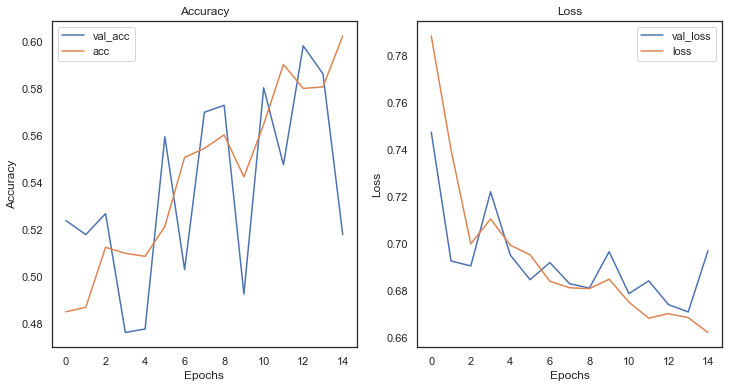

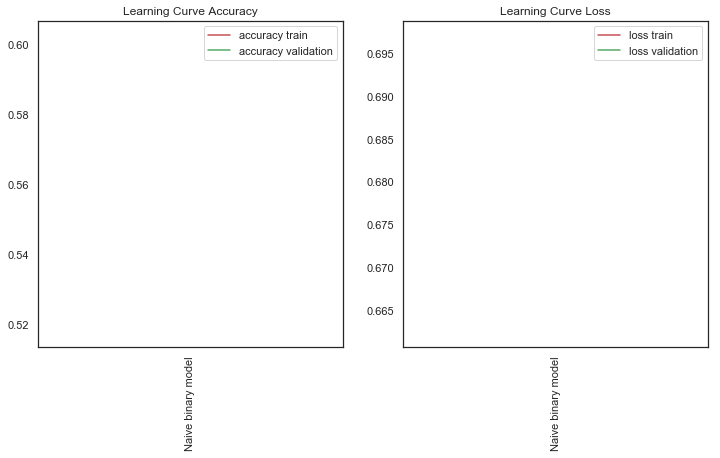

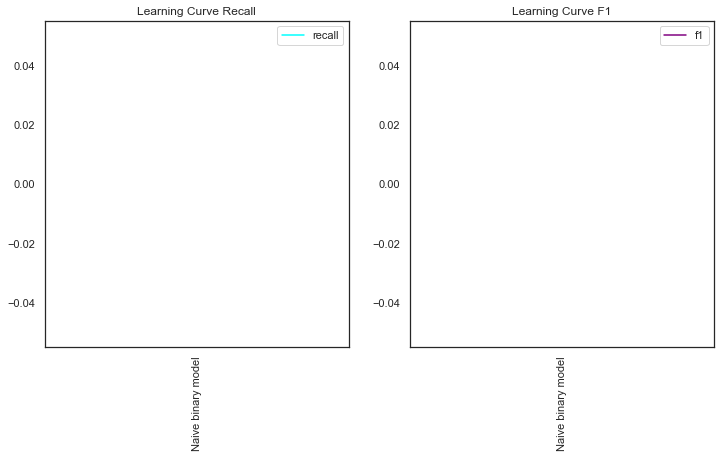

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   

   loss validation  recall   f1  
0          0.69713     0.0  0.0

In [136]:
df=model_results_bin(results=naive_hist, model_name='Naive binary model', df=df, 
                     model=naive_model)
df

### Improving the model:

Redefining `create_model` for the binary case.

In [137]:
def create_model_bin(input_shape=(64, 64, 3), activation='relu', 
                 loss='binary_crossentropy', 
                optimizer='adam',metrics=['acc'] , 
                 neur1=10, neur2=20, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model

In [138]:
model_bina=create_model_bin()

In [139]:
hist_bin1=fit_model(model_bina, train_img64, train_y  )

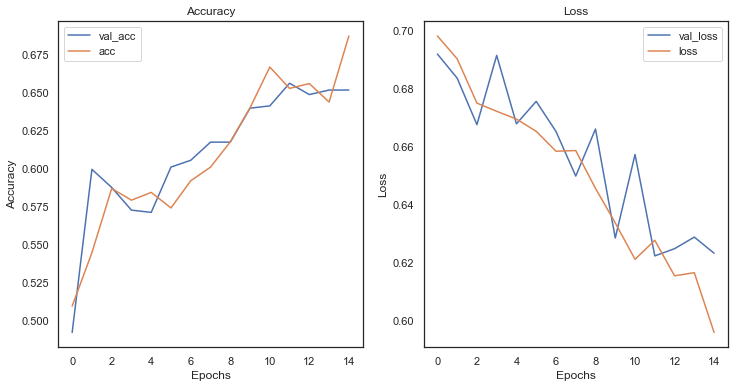

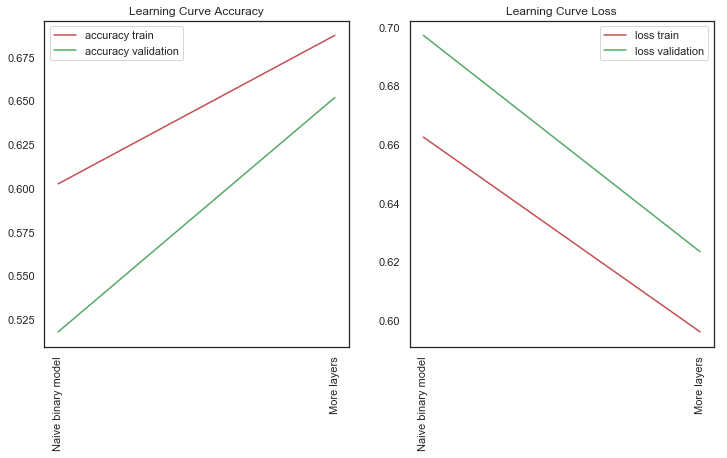

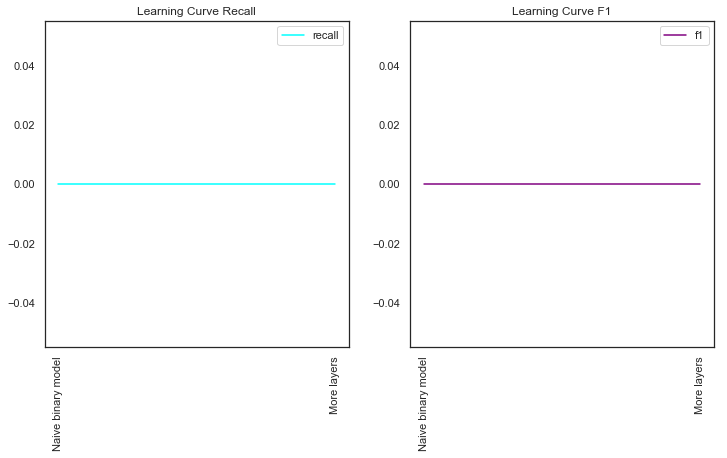

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   

   loss validation  recall   f1  
0          0.69713     0.0  0.0  
0          0.62339     0.0  0.0

In [140]:
df=model_results_bin(model_bina, hist_bin1,'More layers',df)
df

In [141]:
#df=model_results_bin(hist_bin5, 'Binary model batch size 100', df, model_bina, train_img64, train_y)
#df

### Re tuning of the parameters
With this time binary classification problem

### Grid Searches
First we will run the grid search for **batch size and epochs**:

In [ ]:
"""
# Use scikit-learn to grid search the batch size and epochs
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_bin())
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [142]:
#best_batch=best_params['batch_size']
#best_epochs=best_params['epochs']
best_batch=100
best_epochs=50

In [143]:
hist_bin2=fit_model(model_bina, train_img64, train_y , 
                    val_split=0.3, verbose=0 , epo=best_epochs, batch=best_batch)

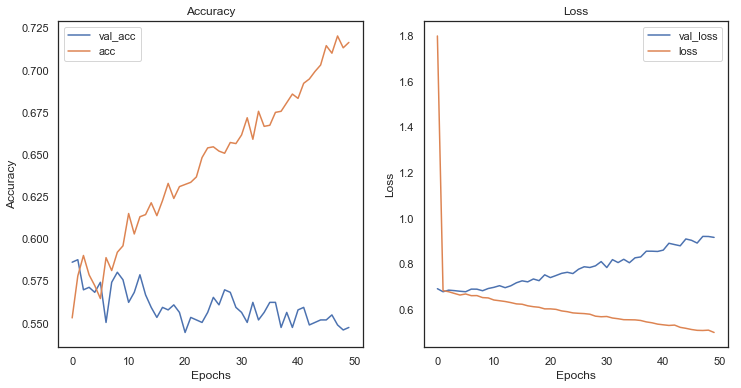

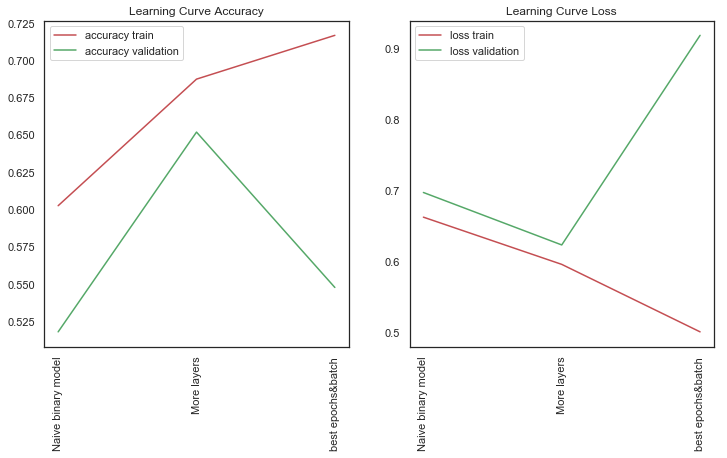

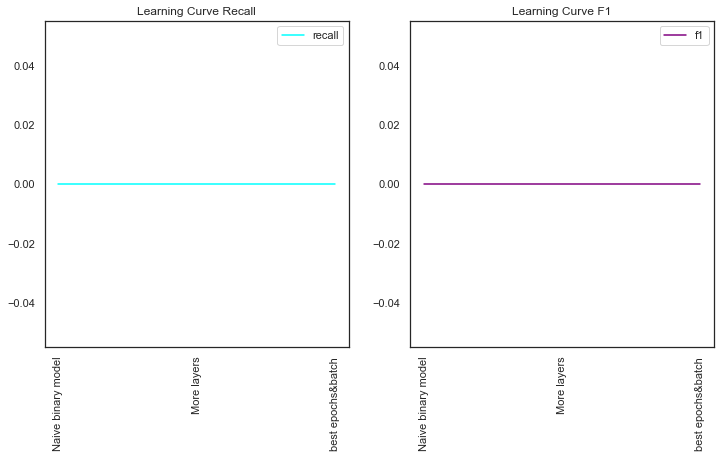

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   

   loss validation  recall   f1  
0          0.69713     0.0  0.0  
0          0.62339     0.0  0.0  
0          0.91797     0.0  0.0

In [144]:
df=model_results_bin(model_bina, hist_bin2, 'best epochs&batch', df)
df

Setting the parameters epochs and batch size that we found as default in our function so we don't need to redifine them every time.

In [145]:
def calculate_metrics(model, trainX=train_img64, trainy=train_y,
                      epochs=best_epochs, batch=best_batch):
    recs=[]
    f1s=[]
    for i in range(10):
        fit_model(model, trainX, trainy, epo=epochs, batch=batch)
    # predict probabilities
        y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
#    y_pred_clas = (model.predict(trainX) > 0.5).astype("int32")
        y_pred_clas = np.argmax(y_pred_prob,axis=1)
#    y_pred_clas =np.round(y_pred_prob).astype(int)
    # reduce to 1d array
        y_pred_prob = y_pred_prob[:, 0]
#        y_pred_clas = y_pred_clas[:, 0]
        recall = recall_score(trainy, y_pred_clas)
        f1 = f1_score(trainy, y_pred_clas)
        recs.append(recall)
        f1s.append(f1)
        i+=1
    recall_mean=np.mean(recs)
    f1_mean=np.mean(f1s)
        
    return recall_mean, f1_mean

Grid Search for **optimization algorithm**:

In [ ]:
"""
# create model
model = KerasClassifier(model=create_model_bin(), 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [146]:
#best_opti=best_params['optimizer']
best_opti='RMSprop'

In [147]:
# Run a model and add the results to the bunch
model_binb=create_model_bin(optimizer=best_opti)

In [148]:
hist_bin3=fit_model(model_binb, train_img64, train_y, epo=best_epochs, batch=best_batch)

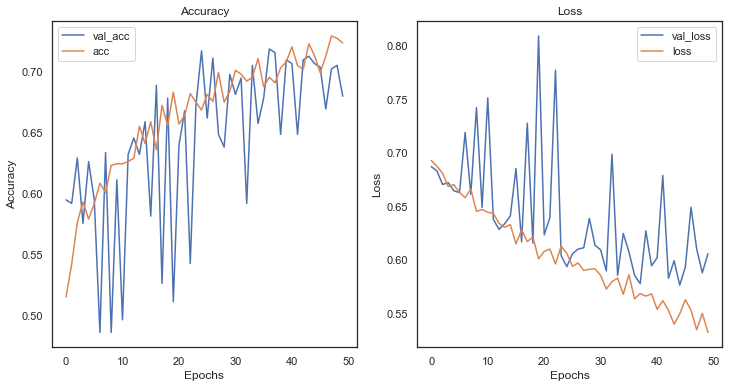

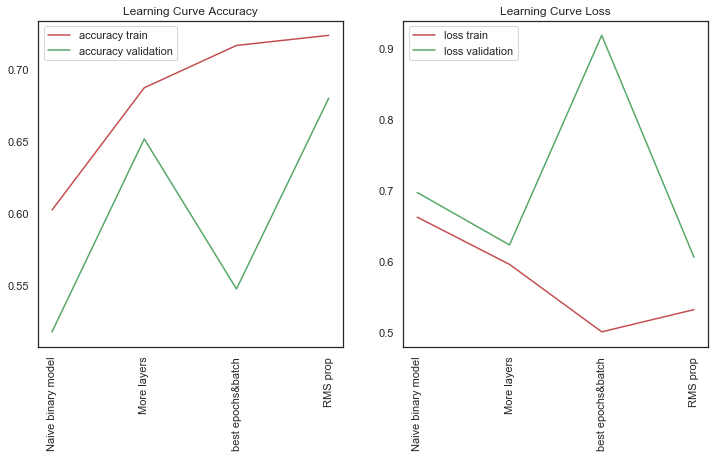

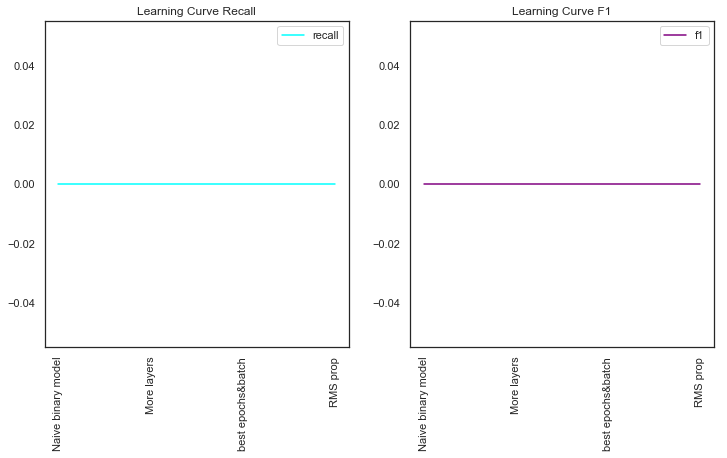

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   

   loss validation  recall   f1  
0          0.69713     0.0  0.0  
0          0.62339     0.0  0.0  
0          0.91797     0.0  0.0  
0          0.60618     0.0  0.0

In [149]:
df=model_results_bin(model_binb, hist_bin3, 'RMS prop', df)
df

### SGD - just in case

In [150]:
# Run a model and add the results to the bunch
model_binb2=create_model_bin(optimizer='sgd')

In [151]:
hist_bin32=fit_model(model_binb2, train_img64, train_y, epo=best_epochs, batch=best_batch, verbose=1)

Epoch 1/50
16/16 [==============================] - 3s 172ms/step - loss: 0.7039 - acc: 0.4860 - val_loss: 0.6892 - val_acc: 0.5238
Epoch 2/50
16/16 [==============================] - 3s 159ms/step - loss: 0.6947 - acc: 0.4852 - val_loss: 0.6896 - val_acc: 0.5238
Epoch 3/50
16/16 [==============================] - 3s 158ms/step - loss: 0.6921 - acc: 0.4893 - val_loss: 0.6899 - val_acc: 0.5253
Epoch 4/50
16/16 [==============================] - 3s 159ms/step - loss: 0.6918 - acc: 0.4965 - val_loss: 0.6903 - val_acc: 0.5670
Epoch 5/50
16/16 [==============================] - 3s 159ms/step - loss: 0.6914 - acc: 0.5388 - val_loss: 0.6902 - val_acc: 0.5744
Epoch 6/50
16/16 [==============================] - 3s 157ms/step - loss: 0.6913 - acc: 0.5616 - val_loss: 0.6902 - val_acc: 0.5982
Epoch 7/50
16/16 [==============================] - 3s 158ms/step - loss: 0.6908 - acc: 0.5970 - val_loss: 0.6904 - val_acc: 0.6146
Epoch 8/50
16/16 [==============================] - 3s 158ms/step - loss: 0.

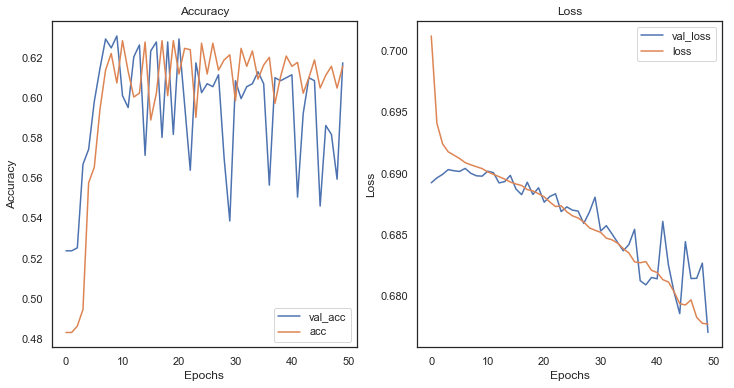

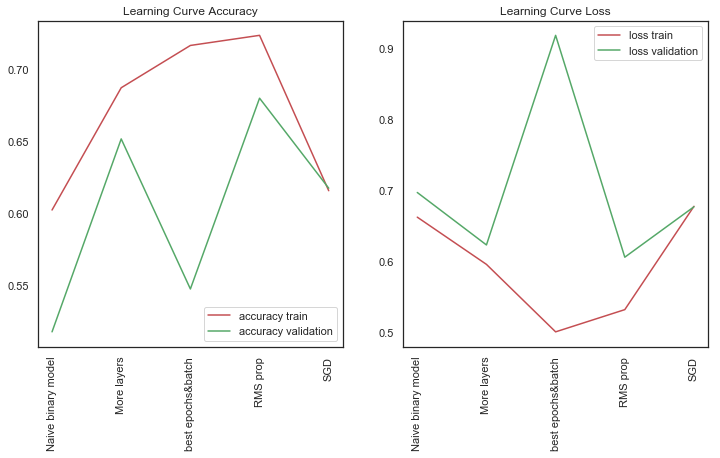

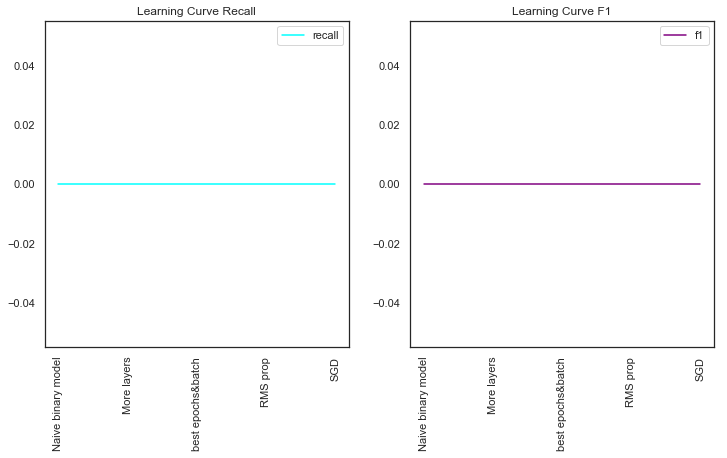

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   

   loss validation  recall   f1  
0          0.69713     0.0  0.0  
0          0.62339     0.0  0.0  
0          0.91797     0.0  0.0  
0          0.60618     0.0  0.0  
0          0.67703     0.0  0.0

In [152]:
df=model_results_bin(model_binb2, hist_bin32, 'SGD', df)
df

### SGD
Grid Search **learning rate and momentum**:

In [ ]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_bin(), loss="binary_crossentropy", 
                        optimizer="SGD", epochs=20, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [153]:
#best_rate=best_params['optimizer__learning_rate']
best_rate=0.1

In [154]:
#best_momentum=best_params['optimizer__momentum']
best_momentum=0.6

In [155]:
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=best_rate, 
                                    momentum=best_momentum)

In [156]:
model_binc=create_model(optimizer=optimizer_sgd)

In [157]:
hist_bin4=fit_model(model_binc, train_img64, train_y, epo=best_epochs, batch=best_batch)

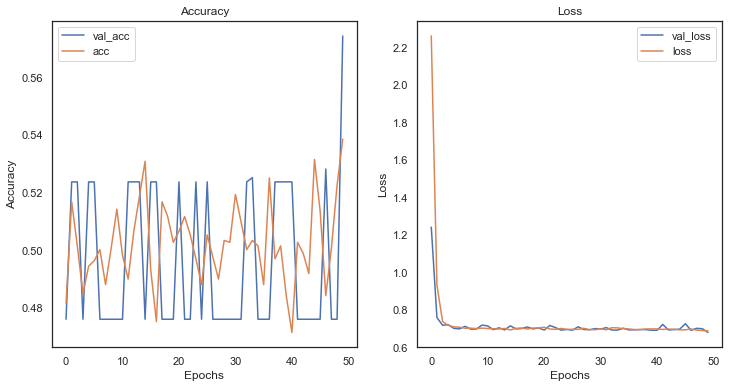

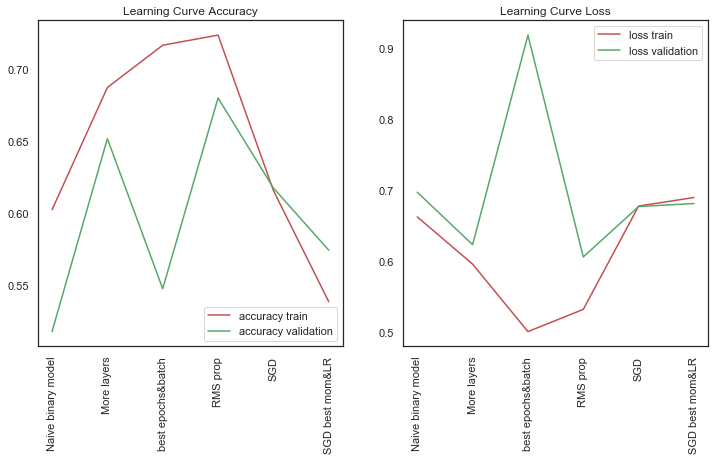

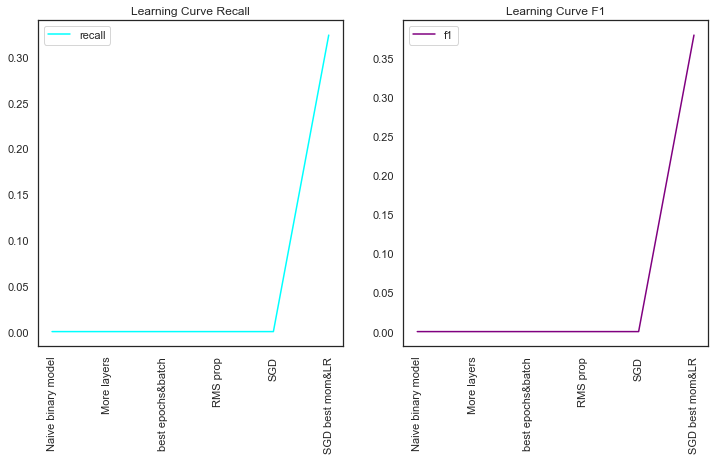

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   
0     SGD best mom&LR         0.53861              0.57440     0.68970   

   loss validation    recall        f1  
0          0.69713  0.000000  0.000000  
0          0.62339  0.000000  0.000000  
0          0.91797  0.000000  0.000000  
0          0.60618  0.000000  0.000000  
0          0.67703  0.000000  0.000000  
0          0.68123  0.323684  0.379169

In [158]:
df=model_results_bin(model_binc, hist_bin4, 'SGD best mom&LR', df)
df

### RMSProp

In [ ]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_bin(), loss="binary_crossentropy", 
                        optimizer="RMSprop", epochs=20, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [159]:
#best_rate=best_params['optimizer__learning_rate']
best_rate=0.01

In [160]:
#best_momentum=best_params['optimizer__weight_decay']
best_momentum=0.6

In [161]:
optimizer_rms = tf.keras.optimizers.RMSprop(learning_rate=0.1, 
                                    momentum=0.2)

In [162]:
model_binc2=create_model(optimizer=optimizer_rms)

In [163]:
hist_bin42=fit_model(model_binc2, train_img64, train_y, epo=best_epochs, batch=best_batch)

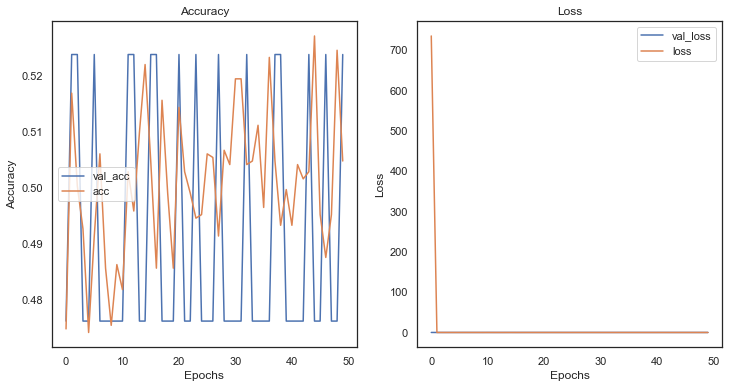

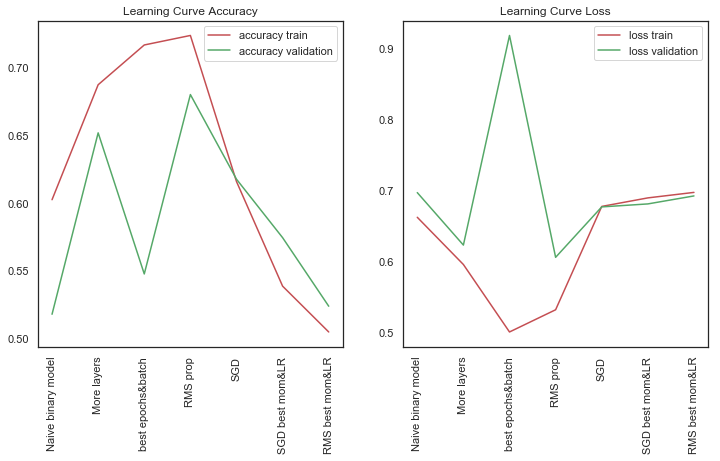

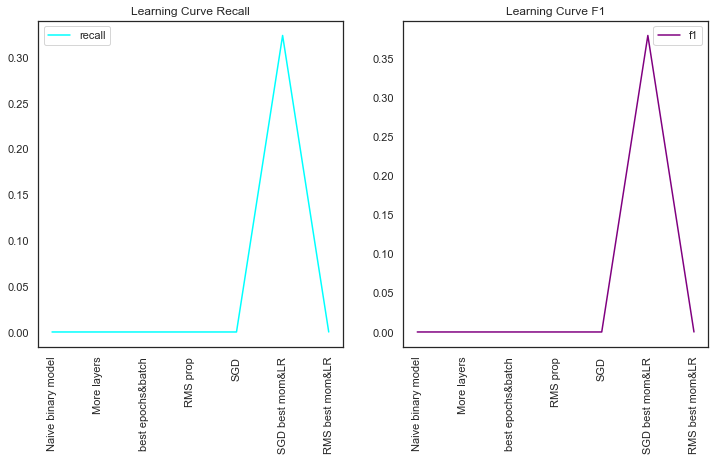

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   
0     SGD best mom&LR         0.53861              0.57440     0.68970   
0     RMS best mom&LR         0.50479              0.52381     0.69742   

   loss validation    recall        f1  
0          0.69713  0.000000  0.000000  
0          0.62339  0.000000  0.000000  
0          0.91797  0.000000  0.000000  
0          0.60618  0.000000  0.000000  
0          0.67703  0.000000  0.000000  
0          0.68123  0.323684  0.379169  
0          0.69246  0.000000  0.000000

In [164]:
df=model_results_bin(model_binc2, hist_bin42, 'RMS best mom&LR', df)
df

Grid Search **Neuron activation function**

In [165]:
# Function to create model, required for KerasClassifier
def create_model_CV_bin(activation='relu'):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(10, (3, 3), activation=activation,
                        input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(10, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(20, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))

 # Compile model
    model.compile(loss='binary_crossentropy', 
                   optimizer=optimizer_rms, metrics=['accuracy'])
    return model

In [ ]:
"""
# create model
model = KerasClassifier(model=create_model_CV_bin, epochs=20, batch_size=20)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 
              'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [166]:
#best_function=best_params['model__activation']
best_function='softsign'

In [167]:
model_bind=create_model(activation=best_function, optimizer=optimizer_rms)

In [168]:
hist_bin5=fit_model(model_bind, train_img64, train_y, epo=best_epochs, batch=best_batch)

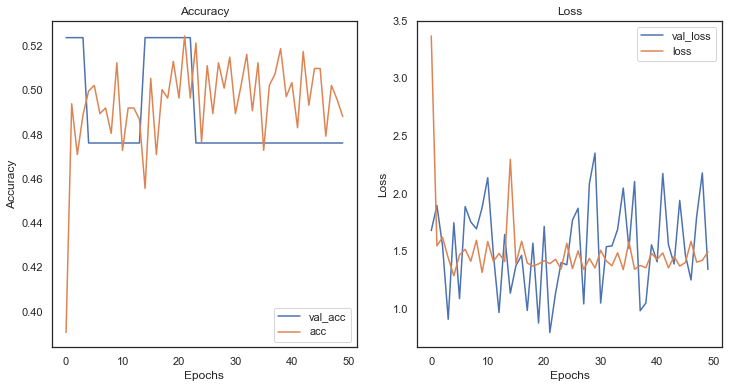

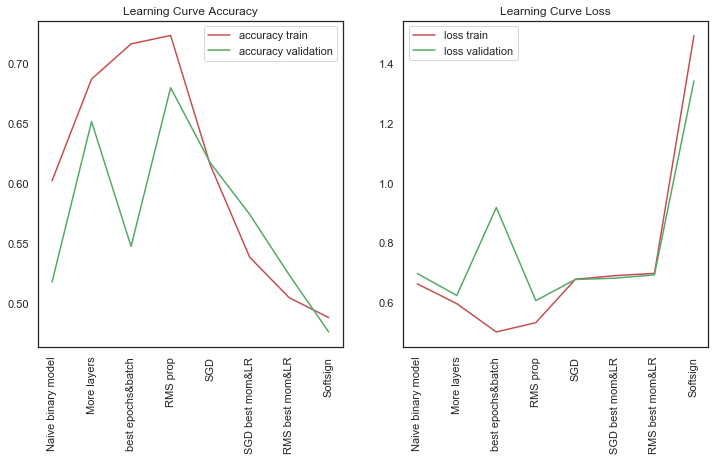

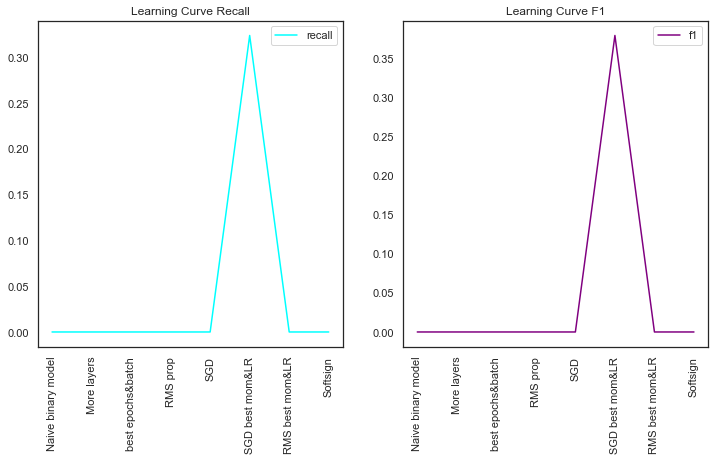

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   
0     SGD best mom&LR         0.53861              0.57440     0.68970   
0     RMS best mom&LR         0.50479              0.52381     0.69742   
0            Softsign         0.48819              0.47619     1.49376   

   loss validation    recall        f1  
0          0.69713  0.000000  0.000000  
0          0.62339  0.000000  0.000000  
0          0.91797  0.000000  0.000000  
0          0.60618  0.000000  0.000000  
0          0.67703  0.000000  0.000000  
0          0.68123  0.323684  0.379169  
0          0.69246  0.000000  0.000000  
0          1.34181  0.000000  0.000000

In [169]:
df=model_results_bin( model_bind, hist_bin5, 'Softsign', df)
df

GridSearch **Number of Neurons:**

In [170]:
# Function to create model, required for KerasClassifier
def create_model_neurons(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation=best_function))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation=best_function))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation=best_function))
    model.add(layers.Dense(1, activation=best_function))

# Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])
    return model

In [171]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_neurons, epochs=100, batch_size=50, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n#set X and Y\nX=train_img64\nY=train_y\n# create model\nmodel = KerasClassifier(model=create_model_neurons, epochs=100, batch_size=50, verbose=0)\n# define the grid search parameters\nneurons = [1, 5, 10, 15, 20, 25, 30]\nparam_grid = dict(model__neurons=neurons)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [172]:
#best_neurons=best_params['model__neurons']
best_neurons=5

In [173]:
model_bine=create_model(activation=best_function, optimizer=optimizer_rms,
                     neur1=best_neurons, neur2=best_neurons)

In [174]:
hist_bin6=fit_model(model_bine, train_img64, train_y, epo=best_epochs, batch=best_batch)

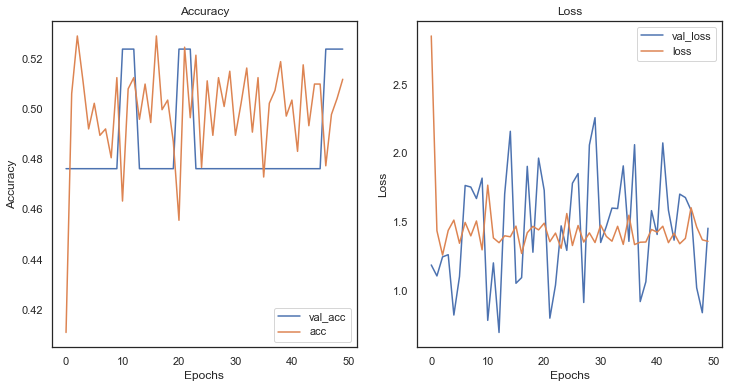

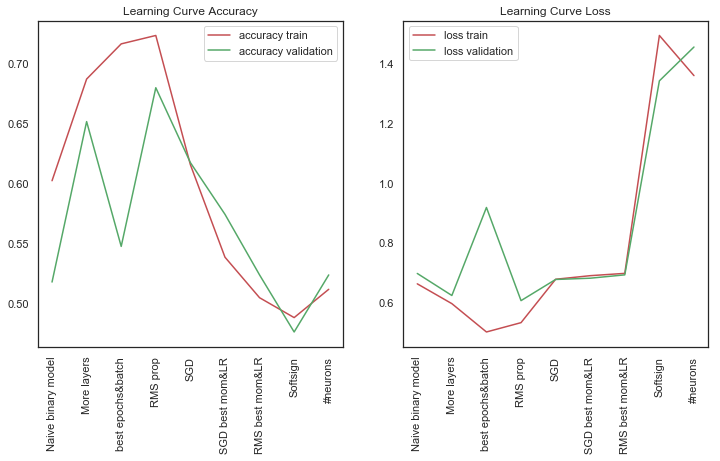

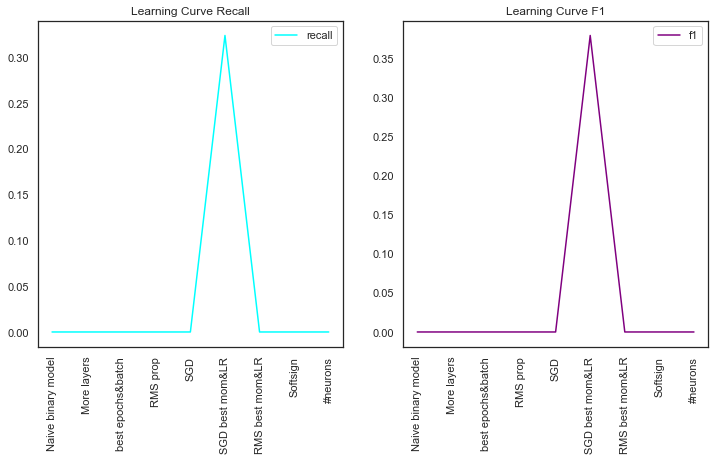

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   
0     SGD best mom&LR         0.53861              0.57440     0.68970   
0     RMS best mom&LR         0.50479              0.52381     0.69742   
0            Softsign         0.48819              0.47619     1.49376   
0            #neurons         0.51181              0.52381     1.35936   

   loss validation    recall        f1  
0          0.69713  0.000000  0.000000  
0          0.62339  0.000000  0.000000  
0          0.91797  0.000000  0.000000  
0          0.60618  0.000000  0.000000  
0          0.67703  0.000000  0.000000  
0          0.68123  0.323684  0.379169  
0          0.69246  0.000000  0.000000  
0          1.34181  0.000000  0.000000  
0          1.45508  0.000000  0.000000

In [175]:
df=model_results_bin(model_bine, hist_bin6, '#neurons', df)
df

### Normalization:

In [176]:
model_binf = models.Sequential()
model_binf.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function))
model_binf.add(layers.MaxPooling2D((2, 2)))
    
model_binf.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function
                         ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_binf.add(layers.MaxPooling2D((2, 2)))
model_binf.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function
                          ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_binf.add(layers.MaxPooling2D((2, 2)))

model_binf.add(layers.Flatten())
model_binf.add(layers.Dense(32, activation=best_function 
                       ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_binf.add(layers.Dense(1, activation=best_function))

# Compile model
model_binf.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])

In [177]:
hist_bin7=fit_model(model_binf, train_img64, train_y, epo=best_epochs, batch=best_batch)

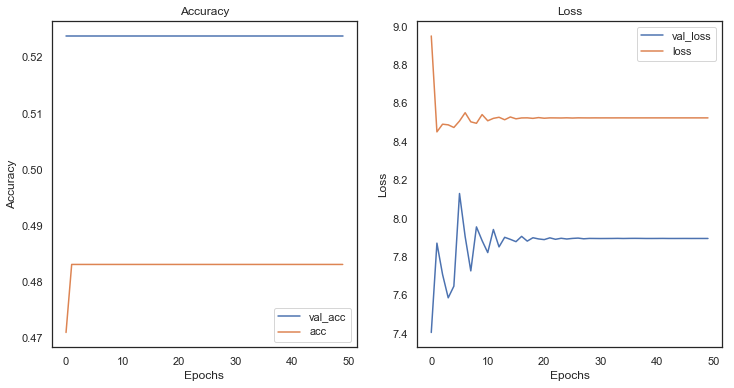

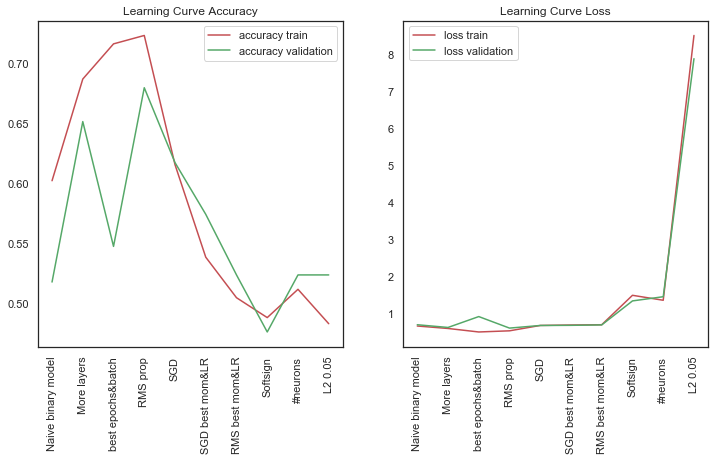

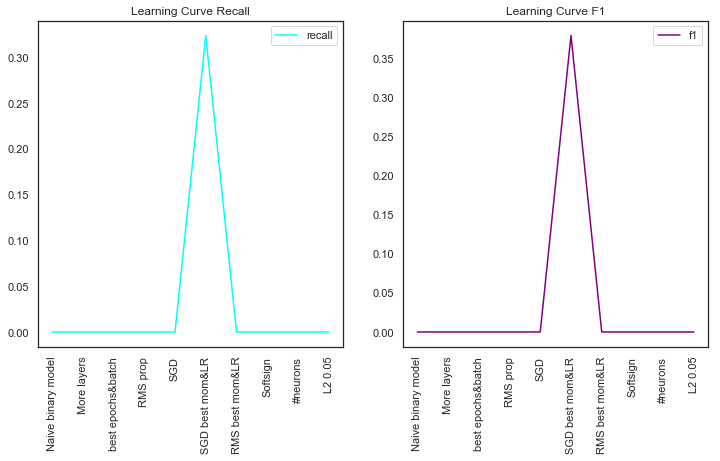

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   
0     SGD best mom&LR         0.53861              0.57440     0.68970   
0     RMS best mom&LR         0.50479              0.52381     0.69742   
0            Softsign         0.48819              0.47619     1.49376   
0            #neurons         0.51181              0.52381     1.35936   
0             L2 0.05         0.48309              0.52381     8.52438   

   loss validation    recall        f1  
0          0.69713  0.000000  0.000000  
0          0.62339  0.000000  0.000000  
0          0.91797  0.000000  0.000000  
0          0.60618  0.000000  0.000000  
0          0.67703  0.000000  0.000000  
0          0.68123  0.323684  0.379169  
0          0.69246  0.000000  0.000000  
0          1.34181  0.000000  0.000000  
0          1.45508  0.000000  0.000000  
0          7.89625  0.000000  0.000000

In [178]:
df=model_results_bin(model_binf, hist_bin7, 'L2 0.05', df)
df

In [179]:
#L2=0.005, 

In [180]:
model_binf1 = models.Sequential()
model_binf1.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function))
model_binf1.add(layers.MaxPooling2D((2, 2)))
    
model_binf1.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function
                         ,kernel_regularizer=regularizers.L2(l2=0.005)))
model_binf1.add(layers.MaxPooling2D((2, 2)))
model_binf1.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function
                          ,kernel_regularizer=regularizers.L2(l2=0.005)))
model_binf1.add(layers.MaxPooling2D((2, 2)))

model_binf1.add(layers.Flatten())
model_binf1.add(layers.Dense(32, activation=best_function 
                       ,kernel_regularizer=regularizers.L2(l2=0.005)))
model_binf1.add(layers.Dense(1, activation=best_function))

# Compile model
model_binf1.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])

In [181]:
hist_bin7b=fit_model(model_binf1, train_img64, train_y, epo=best_epochs, batch=best_batch)

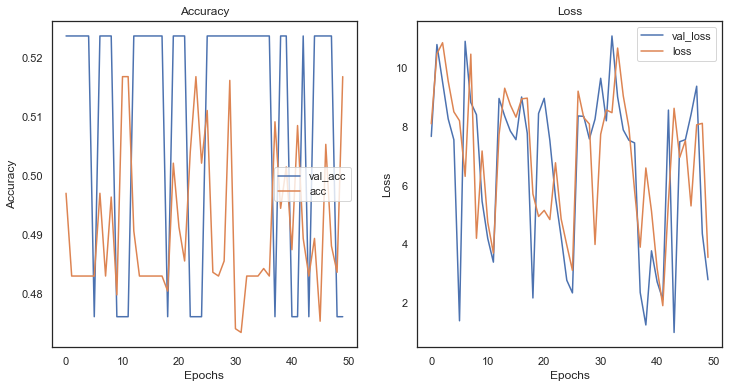

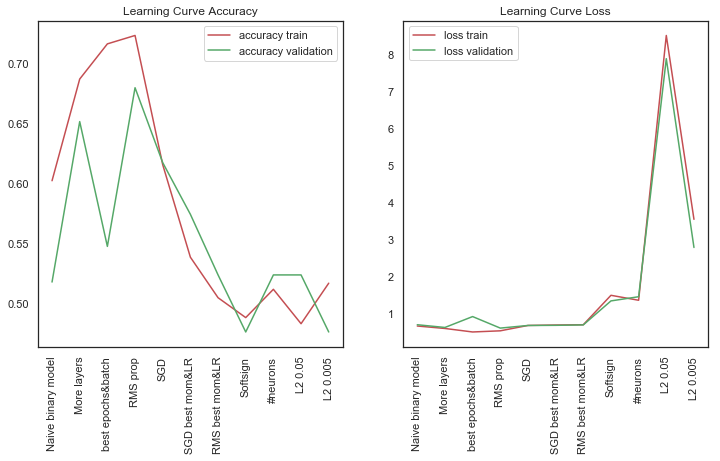

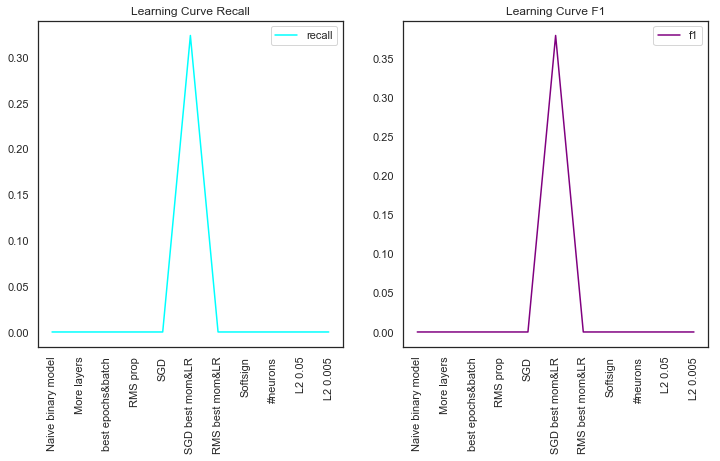

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   
0     SGD best mom&LR         0.53861              0.57440     0.68970   
0     RMS best mom&LR         0.50479              0.52381     0.69742   
0            Softsign         0.48819              0.47619     1.49376   
0            #neurons         0.51181              0.52381     1.35936   
0             L2 0.05         0.48309              0.52381     8.52438   
0            L2 0.005         0.51691              0.47619     3.54900   

   loss validation    recall        f1  
0          0.69713  0.000000  0.000000  
0          0.62339  0.000000  0.000000  
0          0.91797  0.000000  0.000000  
0          0.60618  0.000000  0.000000  
0          0.67703  0.000000  0.000000  
0          0.68123  0.323684  0.379169  
0          0.69246  0.000000  0.000000  
0          1.34181  0.000000  0.000000  
0          1.45508  0.000000  0.000000  
0          7.89625  0.000000  0.000000  
0          2.78760  0.000000  0.000000

In [182]:
df=model_results_bin(model_binf1, hist_bin7b, 'L2 0.005', df)
df

In [183]:
#L2=0.01

In [184]:
model_binf2 = models.Sequential()
model_binf2.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function))
model_binf2.add(layers.MaxPooling2D((2, 2)))
    
model_binf2.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function
                         ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf2.add(layers.MaxPooling2D((2, 2)))
model_binf2.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function
                          ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf2.add(layers.MaxPooling2D((2, 2)))

model_binf2.add(layers.Flatten())
model_binf2.add(layers.Dense(32, activation=best_function 
                       ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf2.add(layers.Dense(1, activation=best_function))

# Compile model
model_binf2.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])

In [185]:
hist_bin7c=fit_model(model_binf2, train_img64, train_y, epo=best_epochs, batch=best_batch)

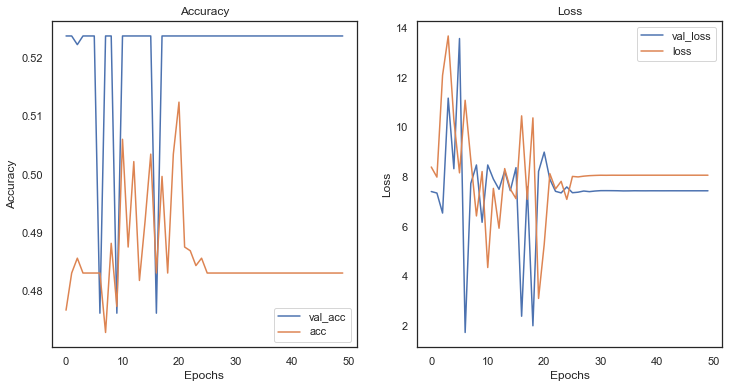

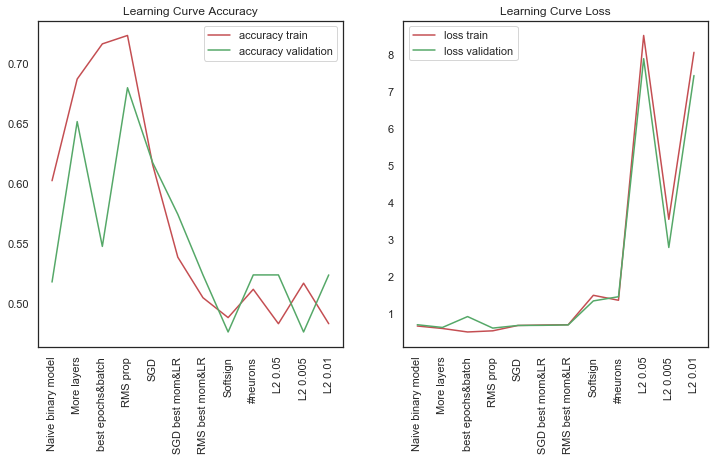

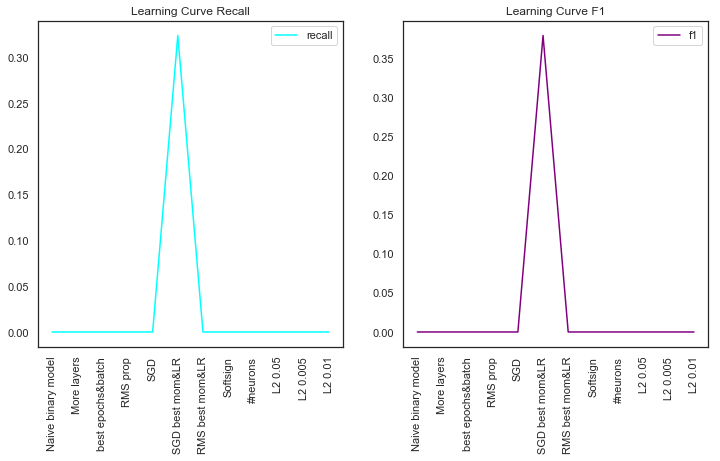

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   
0     SGD best mom&LR         0.53861              0.57440     0.68970   
0     RMS best mom&LR         0.50479              0.52381     0.69742   
0            Softsign         0.48819              0.47619     1.49376   
0            #neurons         0.51181              0.52381     1.35936   
0             L2 0.05         0.48309              0.52381     8.52438   
0            L2 0.005         0.51691              0.47619     3.54900   
0             L2 0.01         0.48309              0.52381     8.06822   

   loss validation    recall        f1  
0          0.69713  0.000000  0.000000  
0          0.62339  0.000000  0.000000  
0          0.91797  0.000000  0.000000  
0          0.60618  0.000000  0.000000  
0          0.67703  0.000000  0.000000  
0          0.68123  0.323684  0.379169  
0          0.69246  0.000000  0.000000  
0          1.34181  0.000000  0.000000  
0          1.45508  0.000000  0.000000  
0          7.89625  0.000000  0.000000  
0          2.78760  0.000000  0.000000  
0          7.44014  0.000000  0.000000

In [186]:
df=model_results_bin(model_binf2, hist_bin7c, 'L2 0.01', df)
df

> remember to change after this the L2 if a different one turns out to be best!!!

### Regularization:

Grid search dropout regularization

In [187]:
# Function to create model, required for KerasClassifier
def create_model_drop(dropout_rate, weight_constraint):

    model = models.Sequential()
    model.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function,
                         kernel_regularizer=regularizers.L2(l2=0.01), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
    model.add(layers.Dropout(dropout_rate))
            

    model.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function, 
                        kernel_regularizer=regularizers.L2(l2=0.01), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
    model.add(layers.Dropout(dropout_rate))            

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=best_function, 
                       kernel_regularizer=regularizers.L2(l2=0.01)))
    model.add(layers.Dense(1, activation=best_function))

# Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])
    return model

In [188]:
"""
# create model
model = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, 
                  model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# create model\nmodel = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)\n# define the grid search parameters\nweight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]\n#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]\ndropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]\nparam_grid = dict(model__dropout_rate=dropout_rate, \n                  model__weight_constraint=weight_constraint)\n#param_grid = dict(model__dropout_rate=dropout_rate)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [189]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [190]:
#best_params=grid_result.best_params_
#best_params

In [191]:
#best_drop=best_params['model__dropout_rate']
best_drop= 0.0 

In [192]:
#best_weight_const=best_params['model__weight_constraint']
best_weight_const = 1.0

In [193]:
model_bing=create_model_drop(dropout_rate=best_drop, weight_constraint=best_weight_const)

In [194]:
hist_bin8=fit_model(model_bing, train_img64, train_y, epo=best_epochs, batch=best_batch)

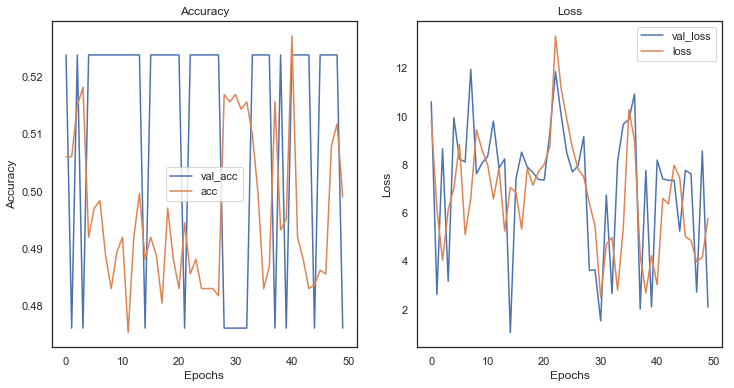

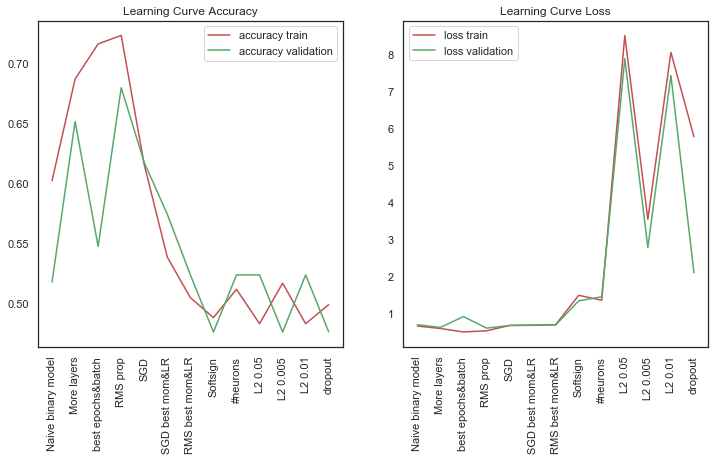

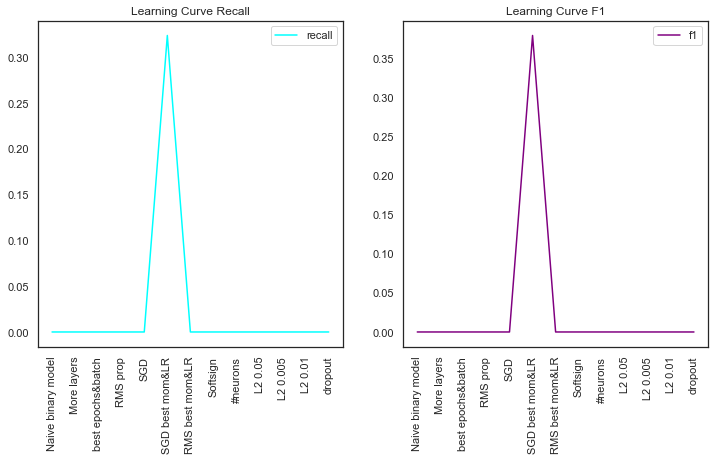

Name  accuracy train  accuracy validation  loss train  \
0  Naive binary model         0.60243              0.51786     0.66245   
0         More layers         0.68730              0.65179     0.59609   
0   best epochs&batch         0.71666              0.54762     0.50126   
0            RMS prop         0.72368              0.68006     0.53248   
0                 SGD         0.61583              0.61756     0.67771   
0     SGD best mom&LR         0.53861              0.57440     0.68970   
0     RMS best mom&LR         0.50479              0.52381     0.69742   
0            Softsign         0.48819              0.47619     1.49376   
0            #neurons         0.51181              0.52381     1.35936   
0             L2 0.05         0.48309              0.52381     8.52438   
0            L2 0.005         0.51691              0.47619     3.54900   
0             L2 0.01         0.48309              0.52381     8.06822   
0             dropout         0.49904              0.47619     5.78329   

   loss validation    recall        f1  
0          0.69713  0.000000  0.000000  
0          0.62339  0.000000  0.000000  
0          0.91797  0.000000  0.000000  
0          0.60618  0.000000  0.000000  
0          0.67703  0.000000  0.000000  
0          0.68123  0.323684  0.379169  
0          0.69246  0.000000  0.000000  
0          1.34181  0.000000  0.000000  
0          1.45508  0.000000  0.000000  
0          7.89625  0.000000  0.000000  
0          2.78760  0.000000  0.000000  
0          7.44014  0.000000  0.000000  
0          2.10145  0.000000  0.000000

In [195]:
df=model_results_bin(model_bing, hist_bin8, 'dropout', df)
df

In [196]:
# Best model

> model_bing or other one, explain why 

### Evaluating on the train and on the test set
#### Loss and Accuracy:

In [ ]:
train_loss, train_acc = model_i.evaluate(train_img64, train_y)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

In [ ]:
train_loss, train_acc = model_binf1.evaluate(train_img64, train_y)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

In [ ]:
train_loss, train_acc =  model_binf1.evaluate(train_img64, train_y)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

In [ ]:
test_loss, test_acc= model_i.evaluate(test_img64, test_y)

print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

### F1 and Recall:

In [ ]:
recall, f1=calculate_metrics(model_binf1, train_img64, train_y)
print(f'On the train set the recall is {recall}\n and the f1 score is {f1}')

In [ ]:
recall, f1=calculate_metrics(model_binf1, test_img64, test_y)
print(f'On the test set the recall is {recall}\n and the f1 score is {f1}')

In [ ]:
    # predict probabilities
y_pred_prob = model_binf1.predict(train_img64, verbose=0)
    # predict classes
y_pred_clas = (model_binf1.predict(train_img64) > 0.5).astype("int32")
    # reduce to 1d array
#    y_pred_prob = y_pred_prob[:, 0]
    y_pred_clas = y_pred_clas[:, 0]
recall = recall_score(train_y, y_pred_clas)
f1 = f1_score(train_y, y_pred_clas)
print('recall', recall, 'f1', f1)
cnm = confusion_matrix(train_y, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Greens")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

## LIME

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(train_img64[0].astype('double'), model_bina.predict,  
                                         top_labels=2, hide_color=0, num_samples=100)

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [ ]:
explanation = explainer.explain_instance(train_img64[11].astype('double'), model_bina.predict,  
                                         top_labels=2, hide_color=0, num_samples=100)

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

> It would be good to run again the best model with highest size images,
and then run the LIME thing like 10 times in a loop
So one can check what parts of the images were used to identify
Even better would be to pick an image that was classified incorrectly VS one that was classified correctly.

### Visualizing activation layers:

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model_bina.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model_bina.input, outputs=layer_outputs)


In [ ]:
model_bina.summary()

In [ ]:
# Returns an array for each activation layer
activations = activation_model.predict(train_img64)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

In [ ]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(train_img64)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(12,10))

layer_names = []
for layer in model_bina.layers[:8]:
    layer_names.append(layer.name)

for i in range(6):
    row = i//3
    column = i%3
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 6], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])